### Import

In [1]:
from google.colab import drive
drive.mount("/content/drive")
import sys
path="/content/drive/My Drive/Colab Notebooks"
htmlblogpath = "/content/drive/MyDrive/Colab Notebooks/Blog/output"
sys.path.append(path)

from BlogHelper.Dependencies import *

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load The Data

`dataset` contains actual load data, load_dam, load_rtpd(average by hour) of `CA_ISO_TAC` from `2021-07-12 07:00:00` to `2022-07-12 06:00:00`. Our target variable is `load_mw_actual`.

In [2]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Blog/data/df_CA_ISO_TAC_one_year.csv', 
                            index_col=0, parse_dates=[0])

In [3]:
dataset

load_mw_actual  load_mw_dam  load_mw_rtpd
time_utc                                                      
2021-07-12 07:00:00           26871        28241   26753.25000
2021-07-12 08:00:00           25503        26645   25152.25000
2021-07-12 09:00:00           24736        25418   24095.75000
2021-07-12 10:00:00           24346        24731   23476.25000
2021-07-12 11:00:00           24451        24820   23566.25000
...                             ...          ...           ...
2022-07-12 02:00:00           38201        39663   38051.50000
2022-07-12 03:00:00           36863        38072   36599.00000
2022-07-12 04:00:00           35063        36416   35313.50000
2022-07-12 05:00:00           32217        33606   32392.25000
2022-07-12 06:00:00           29643        30672   29653.00000

[8623 rows x 3 columns]

#### Plot the data

In [49]:
input_data_plot = plotly_plot_dataset(dataset, write_file=True) # use path=_ to set where to save the plot

white file to /content/drive/MyDrive/Colab Notebooks/Blog/output/input_data.html


### Feature Engineer

#### Temporal Feature: Moving Average

In [8]:
rolling_window_size = 24
target_column = ['load_mw_actual']
dataset[target_column[0]+'_window_mean_24']= dataset[target_column].rolling(rolling_window_size,min_periods=1).mean() # 24hours moving average

#### Temporal Feature: Time

In [9]:
hour = 60*60
day = 24*60*60
day7 = 7*day
year = 365.2524*24*60*60
timestamp_s = dataset.index.map(pd.Timestamp.timestamp)

In [10]:
dataset['hour_sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
dataset['hour_cos'] = np.cos(timestamp_s * (2 * np.pi / hour))
dataset['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
dataset['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
dataset['7day_sin'] = np.sin(timestamp_s * (2 * np.pi / day7))
dataset['7day_cos'] = np.cos(timestamp_s * (2 * np.pi / day7))
dataset['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))

#### Preview Data

In [ ]:
# set the global test start date
# here we decide to use june and july data as the test set
TEST_START = np.where(dataset.index == '2022-06-01 00:00:00')[0][0]
# index where test set start
print('Test Start:', TEST_START)
# shape of the test set
print('Shape of Test Dataset:', dataset[TEST_START:].shape)
# test datetime start and end
print('Test Range From: ', dataset[TEST_START:].index[0])
print('Test Range End:', dataset[TEST_START:].index[-1])

Test Start: 7632
Shape of Test Dataset: (991, 11)
Test Range From:  2022-06-01 00:00:00
Test Range End: 2022-07-12 06:00:00


In [ ]:
summary_table_data = draw_summary_table_data_preview(dataset,width=1200, height=570)

### Generate Time Series Window

#### Configuration

We would use the configuration as below to run this experiment.

In [ ]:
###
TOTAL = dataset.shape[0]
TEST_SIZE = NUM_TEST = TOTAL - TEST_START
print('Testing set Size: ', TEST_SIZE)
NUM_TRAIN_VAL = TEST_START
print('Training set + Validation set Size: ', NUM_TRAIN_VAL)


FOLD = 10
ONE_FOLD_SIZE = ceil(NUM_TRAIN_VAL / (FOLD))
print(f'=' * 50)
print(f'There are {FOLD} folds, each with {ONE_FOLD_SIZE} data.')
SPLIT_RATIO = 0.6611
ONE_TRAIN_SIZE = ceil(ONE_FOLD_SIZE * 0.7)
print(f'One training set size: {ONE_TRAIN_SIZE}')
ONE_VAL_SIZE = ONE_FOLD_SIZE - ONE_TRAIN_SIZE
print(f'One validation set size: {ONE_VAL_SIZE}')

print(f'=' * 50)
target_column=['load_mw_actual']
lookback_width = lw = 12
print(f'Lookback width: {lw}')
target_width = 1
print(f'target width: {target_width}')
hour_pst = 9
prediction_offset = 24
print(f'prediction offset: {prediction_offset}')
BATCH_SIZE = bs = 256
print(f'batch size: {bs}')
lr = 0.0005
print(f'learning rate: {lr}')
p = 15
print(f'patience: {p} ')
###

Testing set Size:  991
Training set + Validation set Size:  7632
There are 10 folds, each with 764 data.
One training set size: 535
One validation set size: 229
Lookback width: 12
target width: 1
prediction offset: 24
batch size: 256
learning rate: 0.0005
patience: 10 


#### Three-way Holdout

The traditional 3wayHold-out

 <img src="https://drive.google.com/uc?export=view&id=1AMoZWjyfRv67BVBF88_qO5VNMROVz7cL" alt="">

In [ ]:
data_window0 = TSCVGenerator(data=dataset,
                            lookback_width=lookback_width, 
                            train_from_front = False,
                            target_width=target_width, 
                            prediction_offset=prediction_offset,
                            split_ratio=SPLIT_RATIO, iftscv = False, 
                            target_columns=target_column)
data_window0

train:(val+test) =  1.95
val:test =  1.95


Total sequence size: 7632
Train sequence size: 5700 
Train indices: [0 1 2 3 4]...[5695 5696 5697 5698 5699]
Val sequence size: 1932
Val indices: [5700 5701 5702 5703 5704]...[7627 7628 7629 7630 7631]
Test sequence size: 991
Test indices: [7632 7633 7634 7635 7636]...[8618 8619 8620 8621 8622]
Total sequence size: 36
Total input size: 12
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [35]
Label column name(s): ['load_mw_actual']

#### Block chaining CV

By setting `train_from_front = False`, we get each trainset window the same size, and under this current setting, trainset data and testset data are not overlapping


 <img src="https://drive.google.com/uc?export=view&id=1VMpzegQ4zWe6FZH781uMIRdn9JFbtL75" alt="">

In [ ]:
data_window2 = TSCVGenerator(data=dataset,
                            lookback_width=lookback_width, 
                            train_from_front = False,
                            BATCH_SIZE = BATCH_SIZE,
                            target_width=target_width, 
                            prediction_offset=prediction_offset,
                            one_train_size=ONE_TRAIN_SIZE, one_val_size=ONE_VAL_SIZE, test_size=TEST_SIZE,
                            target_columns=target_column)
data_window2

Total sequence size: 764
Train sequence size: 535 
Train indices: [0 1 2 3 4]...[530 531 532 533 534]
Val sequence size: 229
Val indices: [535 536 537 538 539]...[759 760 761 762 763]
Test sequence size: 991
Test indices: [7632 7633 7634 7635 7636]...[8618 8619 8620 8621 8622]
Total sequence size: 48
Total input size: 24
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['load_mw_actual']

we could see that we get several train and validation windows. They are not overlapping

In [ ]:
i=0
for train_index, val_index, test_index in data_window2.split():
    print('\n', i, ':')
    print('TRAIN:', len(train_index), '\nVALIDATION:', len(val_index))
    i += 1
print('Total Number of Train/Validation:', i)
# The reason we got 11 folds is that there are additional data cannot be equally splitted into 10 folds, so we use the additional one 
print(data_window2.test[1].shape) 


 0 :
TRIAN: 535 
VALIDATION: 276

 1 :
TRIAN: 535 
VALIDATION: 276

 2 :
TRIAN: 535 
VALIDATION: 276

 3 :
TRIAN: 535 
VALIDATION: 276

 4 :
TRIAN: 535 
VALIDATION: 276

 5 :
TRIAN: 535 
VALIDATION: 276

 6 :
TRIAN: 535 
VALIDATION: 276

 7 :
TRIAN: 535 
VALIDATION: 276

 8 :
TRIAN: 535 
VALIDATION: 276

 9 :
TRIAN: 535 
VALIDATION: 276

 10 :
TRIAN: 535 
VALIDATION: 276
Total Number of Train/Validation: 11
(991, 1)


#### Forward chaining CV

By setting `train_from_front=False`, the size of trainset windows increases. All of them uses all the historic data (index start from 0)

 <img src="https://drive.google.com/uc?export=view&id=191fq1zdKKAw6F-d4YXEiaeVp4rIHYVRF" alt="">

In [ ]:
print(
    f'One Train: {ONE_TRAIN_SIZE}\n'
    f'One Val: {ONE_VAL_SIZE}\n'
    f'One fold: {ONE_TRAIN_SIZE + ONE_VAL_SIZE}\n'
    f'Test Size: {TEST_SIZE}')

BATCH_SIZE=64
target_column=['load_mw_actual']
lookback_width = 24
target_width = 1
hour_pst = 9
prediction_offset = 24
# prediction_offset = 24+ 24 - hour_pst

One Train: 535
One Val: 229
One fold: 764
Test Size: 991


In [ ]:
data_window1 = TSCVGenerator(data=dataset,
                            lookback_width=lookback_width, 
                            train_from_front = True,
                            BATCH_SIZE = BATCH_SIZE,
                            target_width=target_width, 
                            prediction_offset=prediction_offset,
                            one_train_size=ONE_TRAIN_SIZE, one_val_size=ONE_VAL_SIZE, test_size=TEST_SIZE,
                            target_columns=target_column)
data_window1

Total sequence size: 764
Train sequence size: 535 
Train indices: [0 1 2 3 4]...[530 531 532 533 534]
Val sequence size: 229
Val indices: [535 536 537 538 539]...[759 760 761 762 763]
Test sequence size: 991
Test indices: [7632 7633 7634 7635 7636]...[8618 8619 8620 8621 8622]
Total sequence size: 48
Total input size: 24
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['load_mw_actual']

In [ ]:
i=0
for train_index, val_index, test_index in data_window1.split():
    print('\n', i, ':')
    print('TRAIN:', len(train_index), '\n'
          'VALIDATION:', len(val_index))
    i += 1
# The reason we got 11 folds is that there are additional data cannot be equally splitted into 10 folds, so we use the additional one 
print('Total Number of Train/Validation:', i)
print(data_window1.test[1].shape)


 0 :
TRIAN: 535 
VALIDATION: 276

 1 :
TRIAN: 1299 
VALIDATION: 276

 2 :
TRIAN: 2063 
VALIDATION: 276

 3 :
TRIAN: 2827 
VALIDATION: 276

 4 :
TRIAN: 3591 
VALIDATION: 276

 5 :
TRIAN: 4355 
VALIDATION: 276

 6 :
TRIAN: 5119 
VALIDATION: 276

 7 :
TRIAN: 5883 
VALIDATION: 276

 8 :
TRIAN: 6647 
VALIDATION: 276

 9 :
TRIAN: 7411 
VALIDATION: 276

 10 :
TRIAN: 8175 
VALIDATION: 276
Total Number of Train/Validation: 11
(991, 1)


### Training with one trial

#### 3way holdout

Variance within one train

train:(val+test) =  1.95
val:test =  1.95
qrange: 4000.800000000003 median: 24327.0
Epoch 1/200
23/23 [==============================] - 6s 66ms/step - loss: 0.6997 - MAE: 0.6997 - val_loss: 0.5106 - val_MAE: 0.5106
Epoch 2/200
23/23 [==============================] - 0s 18ms/step - loss: 0.5127 - MAE: 0.5127 - val_loss: 0.4161 - val_MAE: 0.4161
Epoch 3/200
23/23 [==============================] - 0s 17ms/step - loss: 0.6012 - MAE: 0.6012 - val_loss: 0.4418 - val_MAE: 0.4418
Epoch 4/200
23/23 [==============================] - 0s 17ms/step - loss: 0.5867 - MAE: 0.5867 - val_loss: 0.4296 - val_MAE: 0.4296
Epoch 5/200
23/23 [==============================] - 0s 17ms/step - loss: 0.3942 - MAE: 0.3942 - val_loss: 0.3324 - val_MAE: 0.3324
Epoch 6/200
23/23 [==============================] - 0s 17ms/step - loss: 0.4829 - MAE: 0.4829 - val_loss: 0.4010 - val_MAE: 0.4010
Epoch 7/200
23/23 [==============================] - 0s 17ms/step - loss: 0.4333 - MAE: 0.4333 - val_loss: 0.3326 - val_MAE:

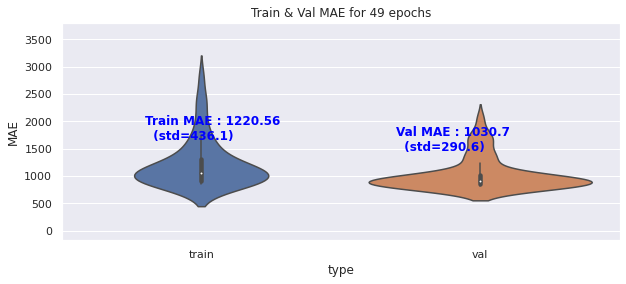

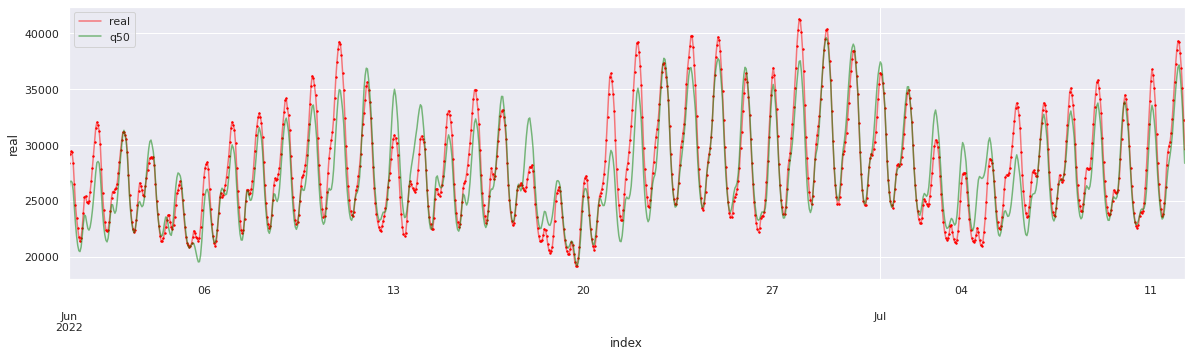

In [ ]:
e0 = experiment(dataset=dataset, lr=lr,
                  BATCH_SIZE = bs, verbose=1, patience=p, MAX_EPOCHS = 200,
                  target_column = target_column, 
                  split_ratio = SPLIT_RATIO ,
                  iftscv=False, # use 3way holdout
                  prediction_offset = prediction_offset,lookback_width = lw,
                  train_from_front=False # default False
                  )
MAE, _ = e0.make_prediction(verbose=True, plot=True)
print(MAE)

In [ ]:
fig = e0.plotly_plot_result()
fig.write_html(os.path.join(htmlblogpath, "3wayholdout_light.html"))
fig

In [ ]:
ddd = pd.DataFrame({'MAE': MAE[0]}, index = ['Three-way Holdout'])
mq = pd.DataFrame({'median': e0.target_median,'qrange': e0.qrange},
                  index = ['Actual Electric Load'])
draw_stats_table(ddd)
tab0 = draw_stats_table(mq, fill_color1='lightskyblue',
                 fill_color2=['lightskyblue'] +['white']*4, line_color = 'lightskyblue')

#### Block chaining cv

qrange: 4000.800000000003 median: 24327.0
Epoch 1/200
22/22 [==============================] - 5s 67ms/step - loss: 0.6873 - MAE: 0.6873 - val_loss: 0.5983 - val_MAE: 0.5983
Epoch 2/200
22/22 [==============================] - 0s 18ms/step - loss: 0.5635 - MAE: 0.5635 - val_loss: 0.7280 - val_MAE: 0.7280
Epoch 3/200
22/22 [==============================] - 0s 18ms/step - loss: 0.6204 - MAE: 0.6204 - val_loss: 0.4068 - val_MAE: 0.4068
Epoch 4/200
22/22 [==============================] - 0s 18ms/step - loss: 0.4346 - MAE: 0.4346 - val_loss: 0.4910 - val_MAE: 0.4910
Epoch 5/200
22/22 [==============================] - 0s 18ms/step - loss: 0.4657 - MAE: 0.4657 - val_loss: 0.5383 - val_MAE: 0.5383
Epoch 6/200
22/22 [==============================] - 0s 18ms/step - loss: 0.4932 - MAE: 0.4932 - val_loss: 0.3811 - val_MAE: 0.3811
Epoch 7/200
22/22 [==============================] - 0s 18ms/step - loss: 0.4159 - MAE: 0.4159 - val_loss: 0.4495 - val_MAE: 0.4495
Epoch 8/200
22/22 [===============

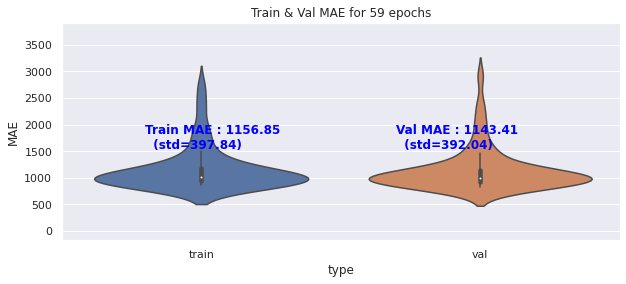

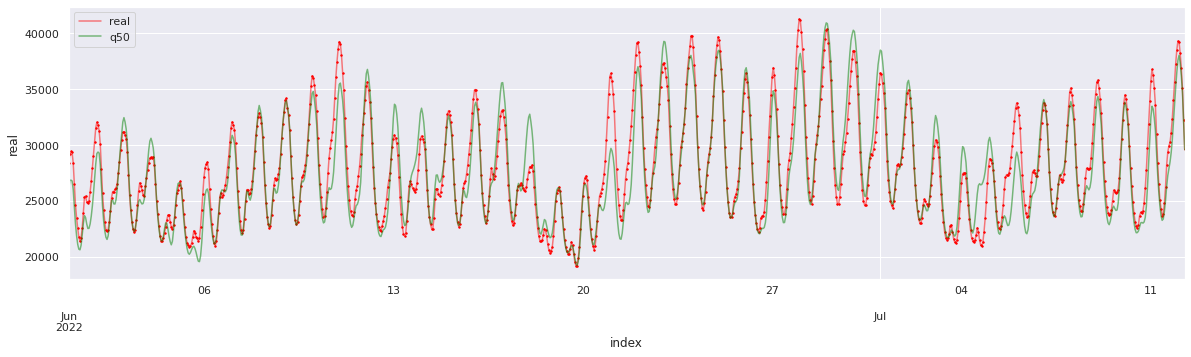

In [ ]:
e1 = experiment(dataset=dataset, lr=lr,
                  BATCH_SIZE = bs, verbose=1, patience=p, MAX_EPOCHS = 200,
                  target_column = target_column, 
                  prediction_offset = prediction_offset,lookback_width = lw,
                  one_train_size=ONE_TRAIN_SIZE,
                  one_val_size = ONE_VAL_SIZE,
                  test_size=TEST_SIZE, 
                  train_from_front=False # default False
                  )
MAE, _  = e1.make_prediction(verbose=True, plot=True)
print(MAE)

In [ ]:
fig = e1.plotly_plot_result()
fig.write_html(os.path.join(htmlblogpath, "blockchaining_light.html"))
fig

In [ ]:
ddd1 = pd.DataFrame({'MAE': MAE[0]}, index = ['Block chaining'])
pd_two = pd.concat([ddd, ddd1])
tab2= draw_stats_table(pd_two)

#### forward chaining cv

qrange: 4000.800000000003 median: 24327.0
Epoch 1/200
186/186 [==============================] - 9s 21ms/step - loss: 0.4775 - MAE: 0.4775 - val_loss: 0.4062 - val_MAE: 0.4062
Epoch 2/200
186/186 [==============================] - 3s 15ms/step - loss: 0.3199 - MAE: 0.3199 - val_loss: 0.3019 - val_MAE: 0.3019
Epoch 3/200
186/186 [==============================] - 3s 15ms/step - loss: 0.2736 - MAE: 0.2736 - val_loss: 0.2393 - val_MAE: 0.2393
Epoch 4/200
186/186 [==============================] - 3s 15ms/step - loss: 0.2386 - MAE: 0.2386 - val_loss: 0.2646 - val_MAE: 0.2646
Epoch 5/200
186/186 [==============================] - 3s 15ms/step - loss: 0.2331 - MAE: 0.2331 - val_loss: 0.2662 - val_MAE: 0.2662
Epoch 6/200
186/186 [==============================] - 3s 15ms/step - loss: 0.2277 - MAE: 0.2277 - val_loss: 0.2586 - val_MAE: 0.2586
Epoch 7/200
186/186 [==============================] - 3s 15ms/step - loss: 0.2251 - MAE: 0.2251 - val_loss: 0.2837 - val_MAE: 0.2837
Epoch 8/200
186/186 

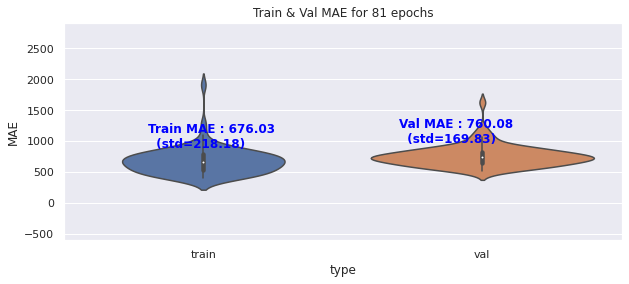

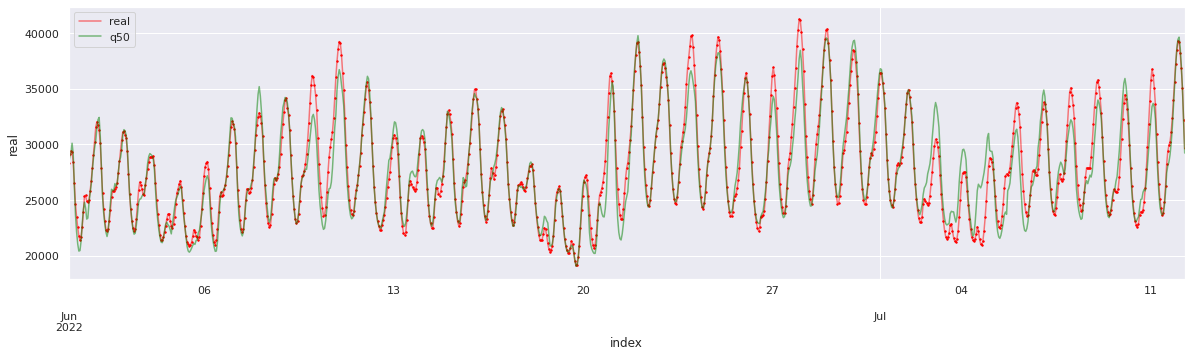

In [ ]:
e2 = experiment(dataset=dataset, lr=lr,
                  BATCH_SIZE = bs, verbose=1, patience=p, MAX_EPOCHS = 200,
                  target_column = target_column, 
                  prediction_offset = prediction_offset,lookback_width = lw,
                  one_train_size=ONE_TRAIN_SIZE,
                  one_val_size = ONE_VAL_SIZE,
                  test_size=TEST_SIZE, 
                  train_from_front=True # default False
)
MAE, _ =  e2.make_prediction(verbose=True, plot=True)
print(MAE)

In [ ]:
fig = e2.plotly_plot_result()
fig.write_html(os.path.join(htmlblogpath, "forwardchaining_light.html"))
fig

In [ ]:
ddd2 = pd.DataFrame({'MAE': MAE[0]}, index = ['Forward chaining'])
pd_three = pd.concat([pd_two, ddd2])
tab2 = draw_stats_table(pd_three) 

#### Comparison with CAISO

In [ ]:
 final_dataset = pd.concat([
    pd.DataFrame({'real': e2.result_df.copy().real,
                  'q50':dataset['load_mw_dam'].iloc[TEST_START:].values,
                  'type':'caiso'
    }),
    pd.DataFrame({'real': e2.result_df.copy().real,
                  'q50': e2.result_df.copy().q50,
                  'type': 'block chaining'})
], axis = 0)
 final_dataset

real         q50            type
index                                                      
2022-06-01 00:00:00 28375.00000 25782.00000           caiso
2022-06-01 01:00:00 29189.00000 27311.00000           caiso
2022-06-01 02:00:00 29430.00000 28030.00000           caiso
2022-06-01 03:00:00 29353.00000 28268.00000           caiso
2022-06-01 04:00:00 28407.00000 27495.00000           caiso
...                         ...         ...             ...
2022-07-12 02:00:00 38201.00000 38735.52734  block chaining
2022-07-12 03:00:00 36863.00000 37065.50781  block chaining
2022-07-12 04:00:00 35063.00000 35041.81250  block chaining
2022-07-12 05:00:00 32217.00000 31996.53320  block chaining
2022-07-12 06:00:00 29643.00000 29230.43359  block chaining

[1982 rows x 3 columns]

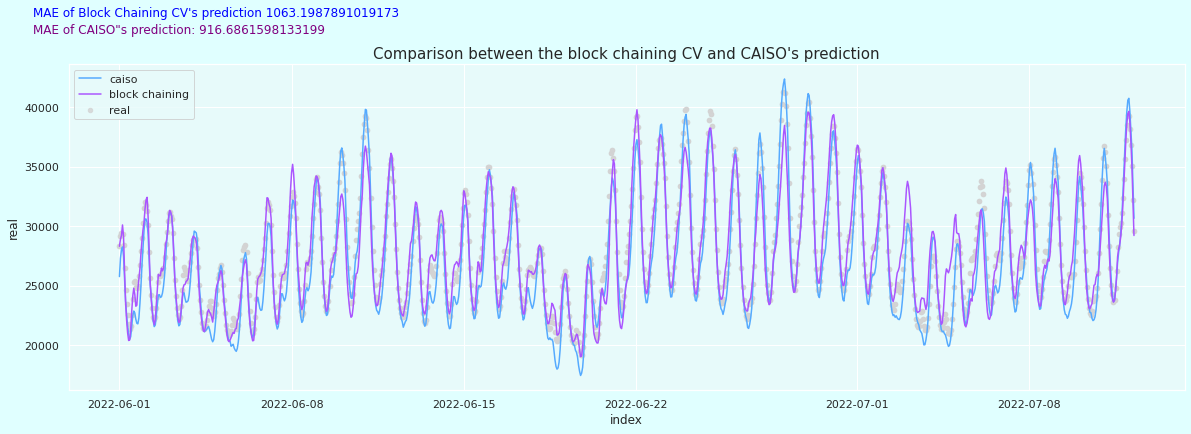

In [ ]:
MAE_BC = np.mean(np.abs(final_dataset[final_dataset['type'] == 'caiso']['q50'] - final_dataset[final_dataset['type'] == 'caiso']['real']))
MAE_CAISO = np.mean(np.abs(final_dataset[final_dataset['type'] == 'block chaining']['q50'] - final_dataset[final_dataset['type'] == 'block chaining']['real']))


sns.set(rc={'figure.figsize':(20, 6),
                'axes.facecolor':'#e7fafa', 
                'figure.facecolor':'lightcyan'})

fig, ax = plt.subplots(1, 1)
sns.lineplot(x='index', y='q50',hue = 'type', data = final_dataset.reset_index(), palette="cool", ax=ax)
ax = sns.regplot(x='index', y='real', data = final_dataset.reset_index(), fit_reg=False, marker="o", color="lightgrey", scatter_kws={'s':20}, label='real', ax=ax)
fig.text(0.1, 0.99, f"MAE of Block Chaining CV's prediction {MAE_BC}", horizontalalignment='left', size='medium', color='blue')
fig.text(0.1, 0.95, f'MAE of CAISO"s prediction: {MAE_CAISO}', horizontalalignment='left', size='medium', color='purple')
plt.title("Comparison between the block chaining CV and CAISO's prediction", fontsize=15)
plt.legend()
plt.show()

#### plot the residuals

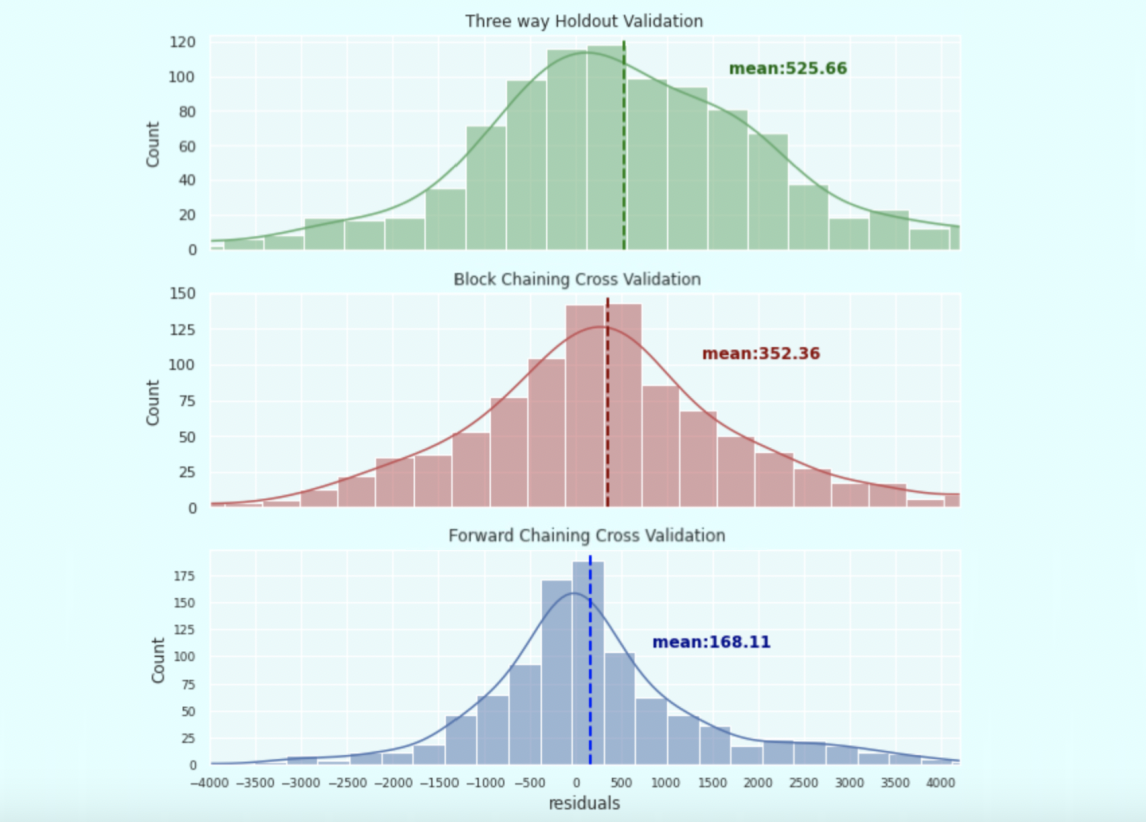

In [22]:
res0 = e0.y_real - e0.y_pred
pd_res0 = pd.DataFrame({'residuals': ([i[0] for i in res0])})
res1 = e1.y_real - e1.y_pred
pd_res1 = pd.DataFrame({'residuals': ([i[0] for i in res1])})
res2 = e2.y_real - e2.y_pred
pd_res2 = pd.DataFrame({'residuals': ([i[0] for i in res2])})

fig, axs = plt.subplots(3, 1, figsize =(10,10), sharex=True)
sns.histplot(data=pd_res0, x="residuals", bins=30,kde=True,ax=axs[0], color= 'g')
axs[0].set_title('Three way Holdout Validation')
axs[0].axvline(res0.mean(), color='green', linestyle='dashed', linewidth=2)
axs[0].text(res0.mean()+res0.std(), 90, f'mean:{round(res0.mean(),2)}\n', horizontalalignment='center', color='darkgreen', weight='semibold')
axs[0].set_xlim(-4000, 4200)
axs[0].set_xticks(range(-4000, 4200, 500))

sns.histplot(data=pd_res1, x="residuals", bins=30, kde=True,ax=axs[1], color= 'r')
axs[1].set_title('Block Chaining Cross Validation')
axs[1].axvline(res1.mean(), color='darkred', linestyle='dashed', linewidth=2)
axs[1].text(res1.mean()+res1.std(), 90, f'mean:{round(res1.mean(),2)}\n', horizontalalignment='center', color='darkred', weight='semibold')

sns.histplot(data=pd_res2, x="residuals", bins=30, kde=True,ax=axs[2], color= 'b')
axs[2].set_title('Forward Chaining Cross Validation')
axs[2].axvline(res2.mean(), color='blue', linestyle='dashed', linewidth=2)
axs[2].text(res2.mean()+res2.std(), 90, f'mean:{round(res2.mean(),2)}\n', horizontalalignment='center', color='darkblue', weight='semibold')
axs[2].tick_params(axis='both', which='major', labelsize=9)
fig.savefig("/content/drive/MyDrive/Colab Notebooks/Blog/Image/residual.png")

### Variance of Modelling

##### 3way holdout

# 1
train:(val+test) =  1.95
val:test =  1.95
qrange: 4000.800000000003 median: 24327.0
Epoch 1/200
23/23 [==============================] - 5s 66ms/step - loss: 0.6989 - MAE: 0.6989 - val_loss: 0.4911 - val_MAE: 0.4911
Epoch 2/200
23/23 [==============================] - 0s 18ms/step - loss: 0.5342 - MAE: 0.5342 - val_loss: 0.4364 - val_MAE: 0.4364
Epoch 3/200
23/23 [==============================] - 0s 17ms/step - loss: 0.5981 - MAE: 0.5981 - val_loss: 0.4362 - val_MAE: 0.4362
Epoch 4/200
23/23 [==============================] - 0s 17ms/step - loss: 0.4990 - MAE: 0.4990 - val_loss: 0.3876 - val_MAE: 0.3876
Epoch 5/200
23/23 [==============================] - 0s 18ms/step - loss: 0.4553 - MAE: 0.4553 - val_loss: 0.3474 - val_MAE: 0.3474
Epoch 6/200
23/23 [==============================] - 0s 18ms/step - loss: 0.4273 - MAE: 0.4273 - val_loss: 0.3346 - val_MAE: 0.3346
Epoch 7/200
23/23 [==============================] - 0s 17ms/step - loss: 0.4787 - MAE: 0.4787 - val_loss: 0.4154 - val_

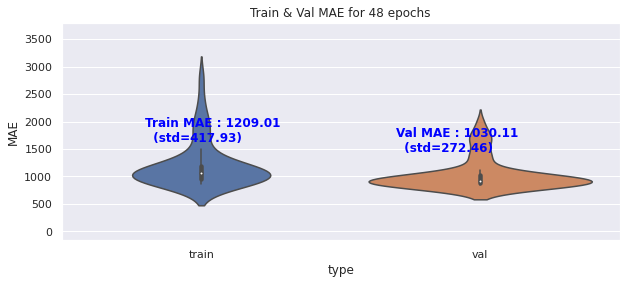

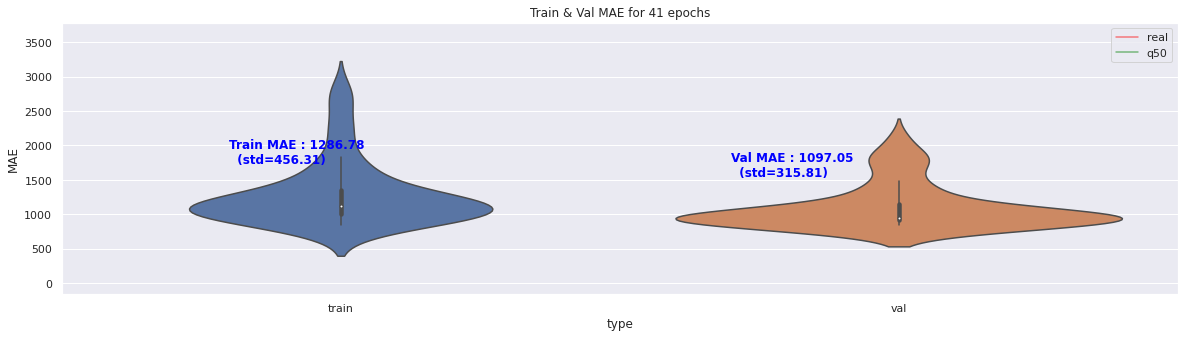

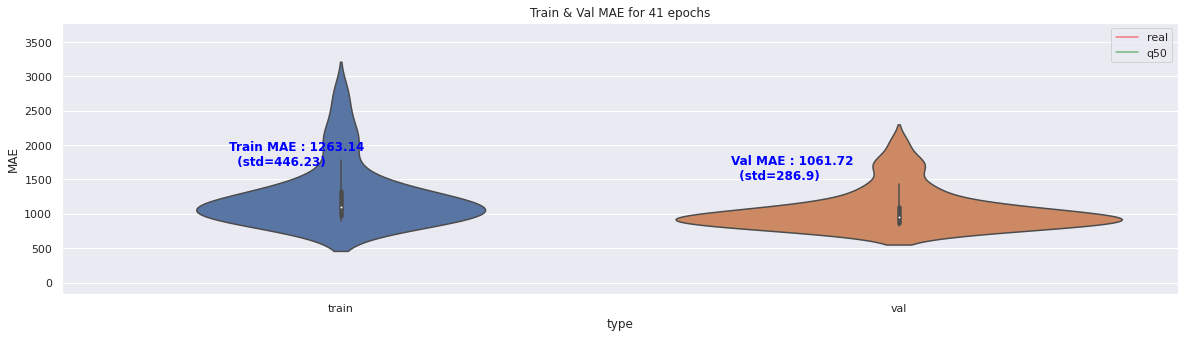

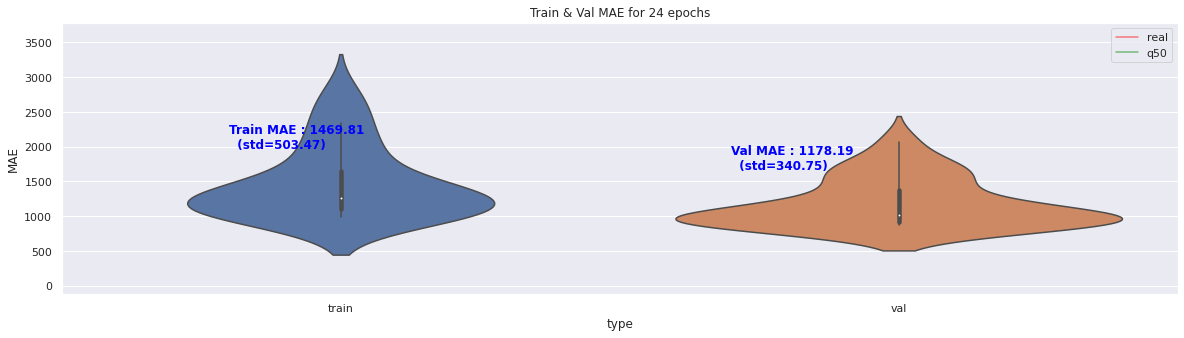

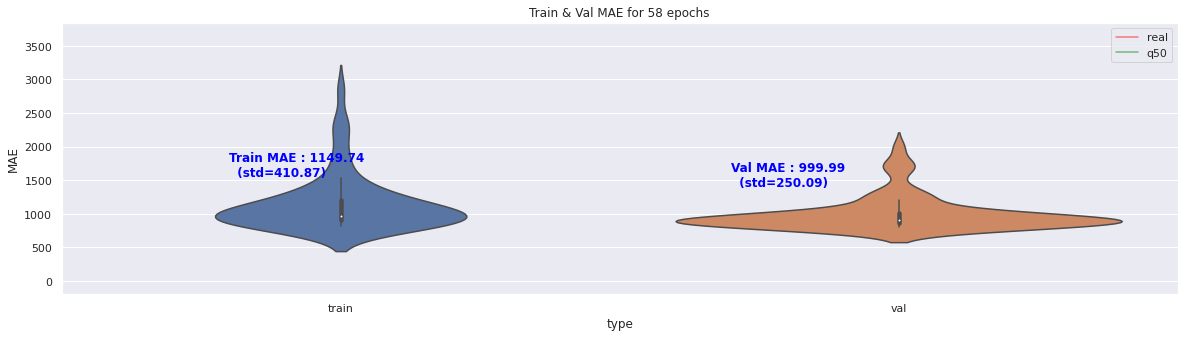

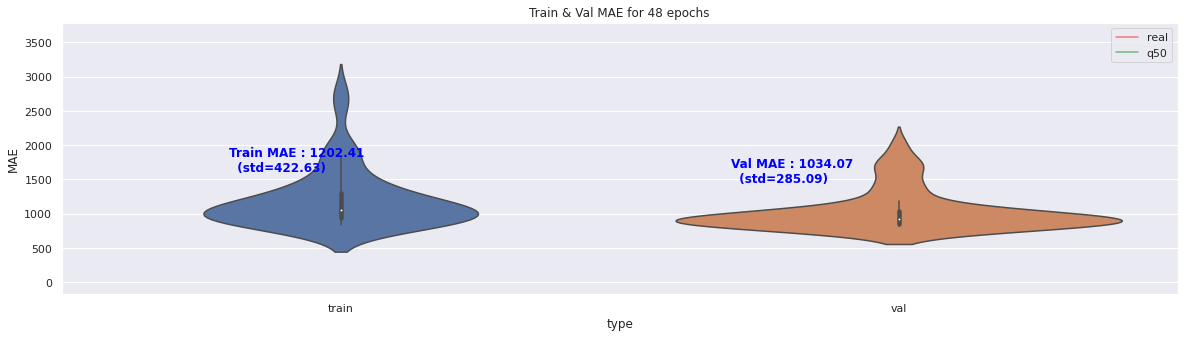

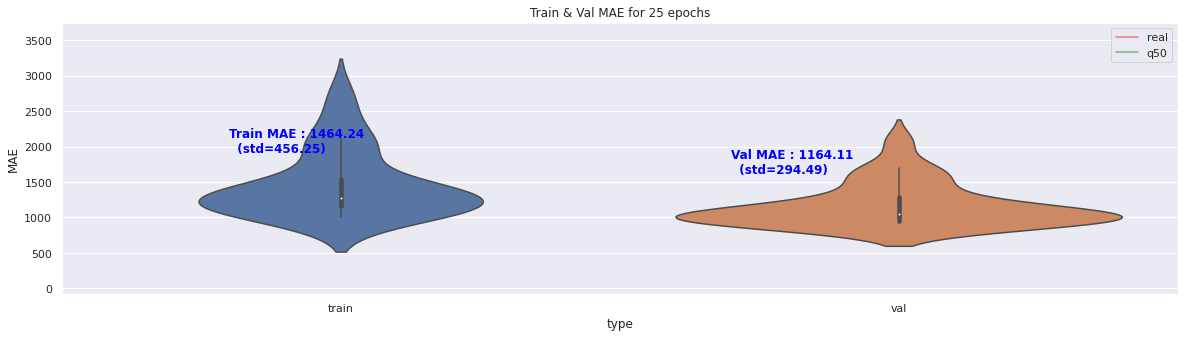

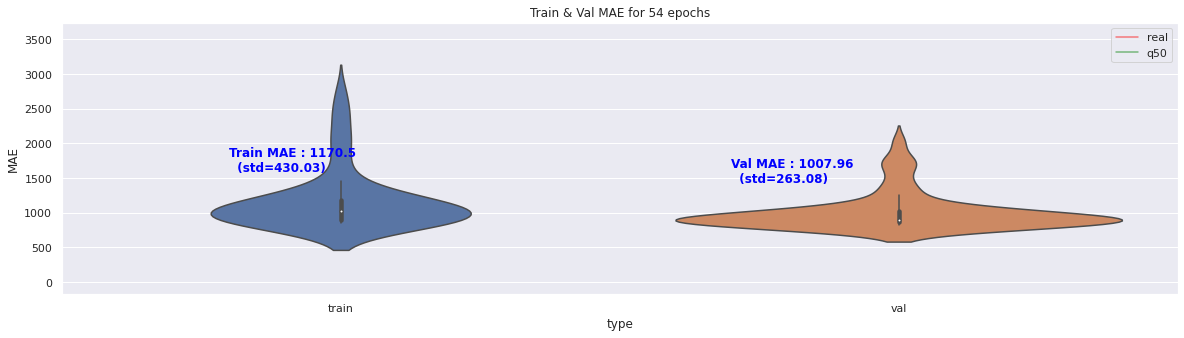

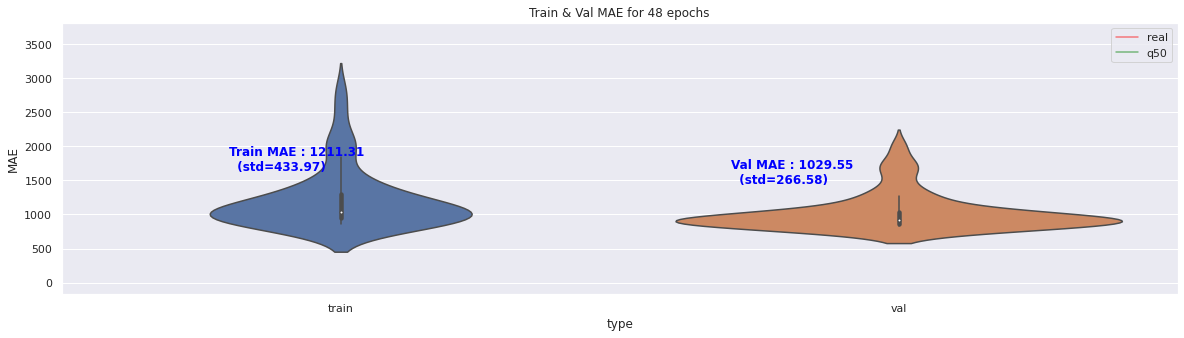

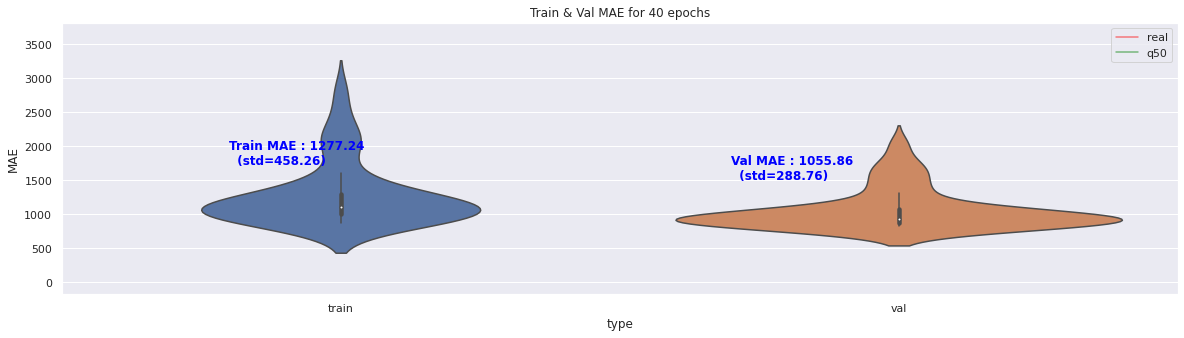

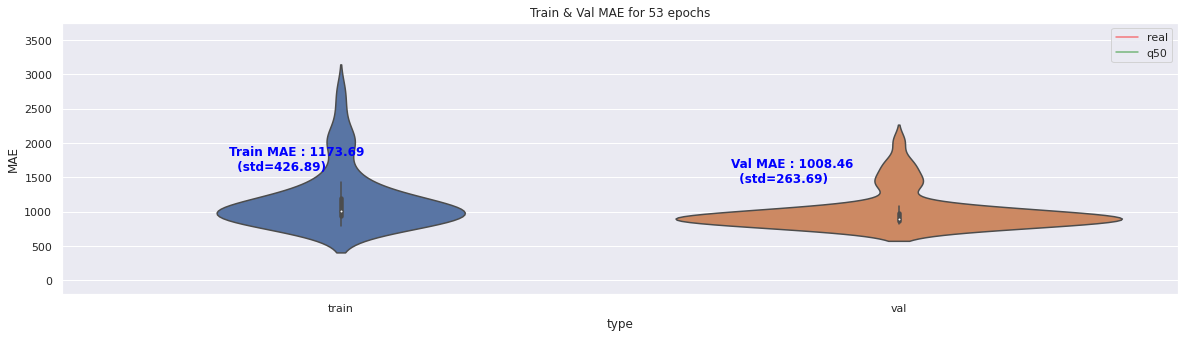

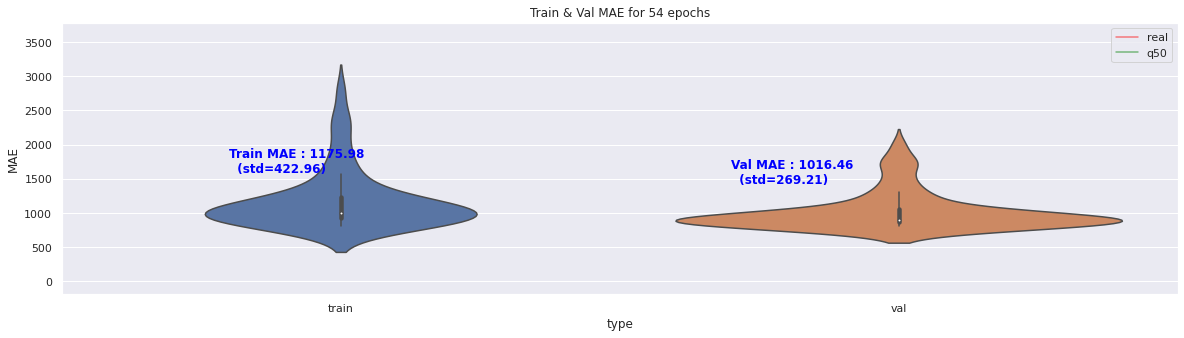

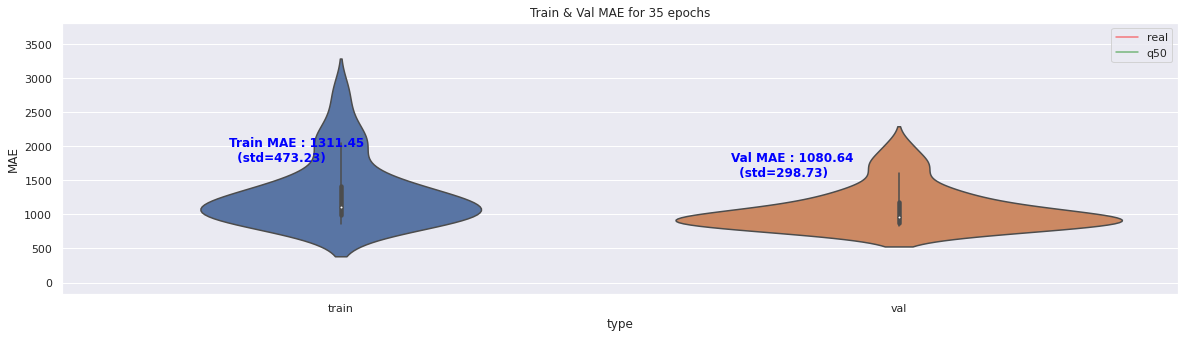

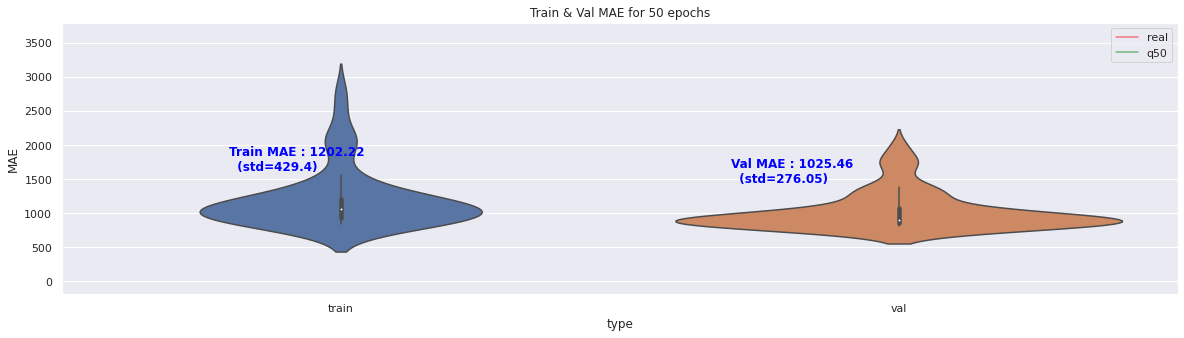

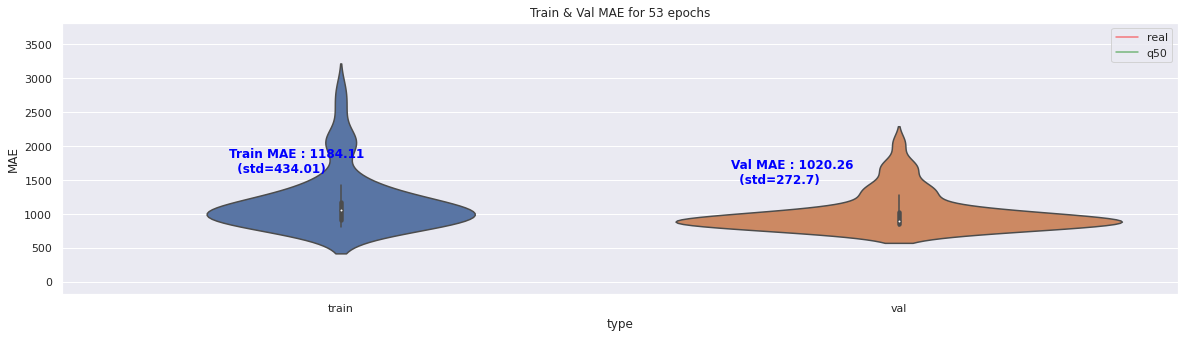

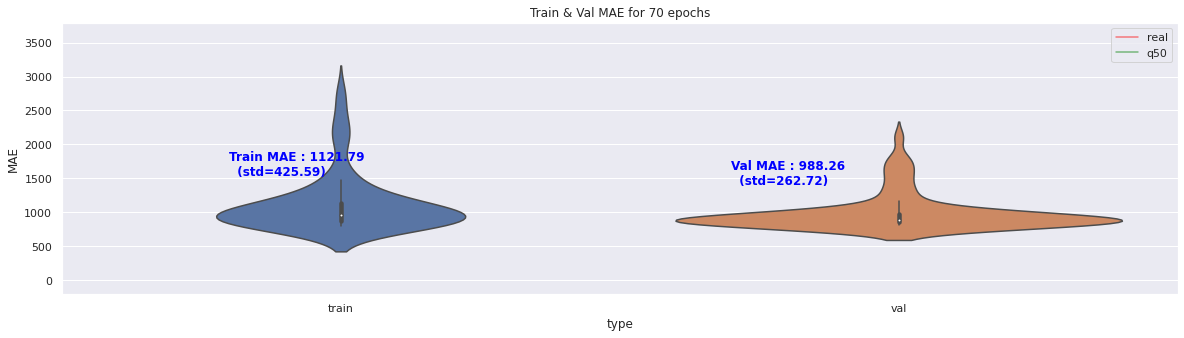

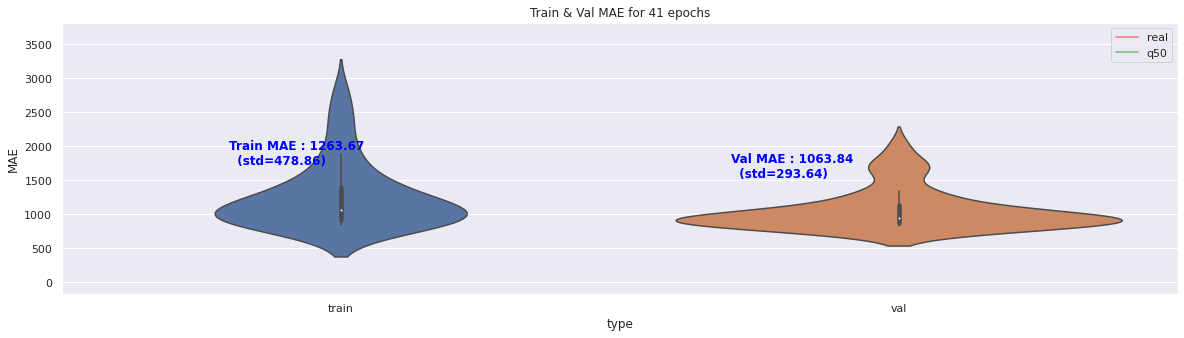

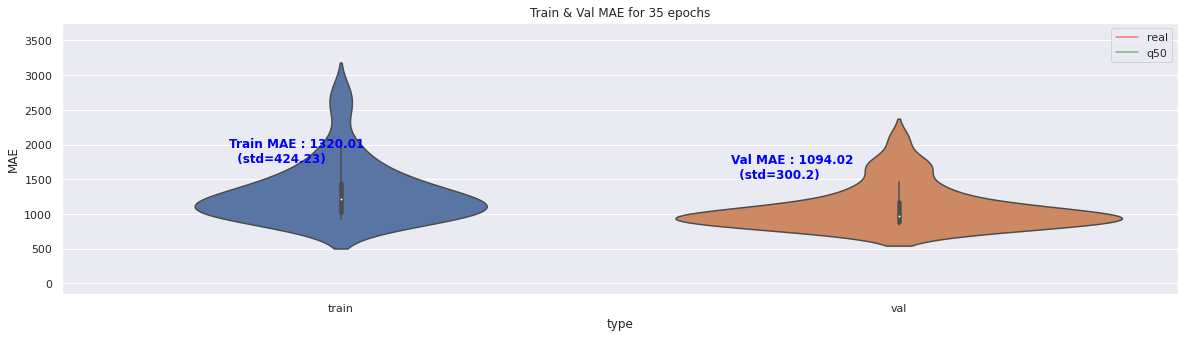

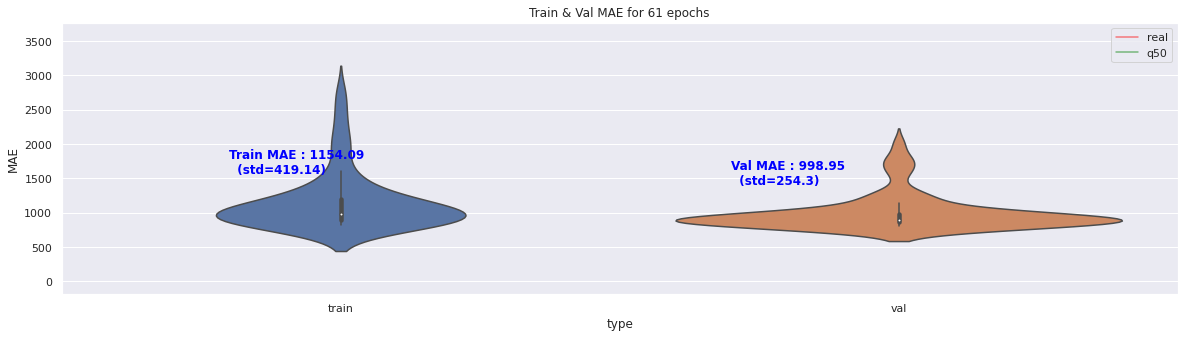

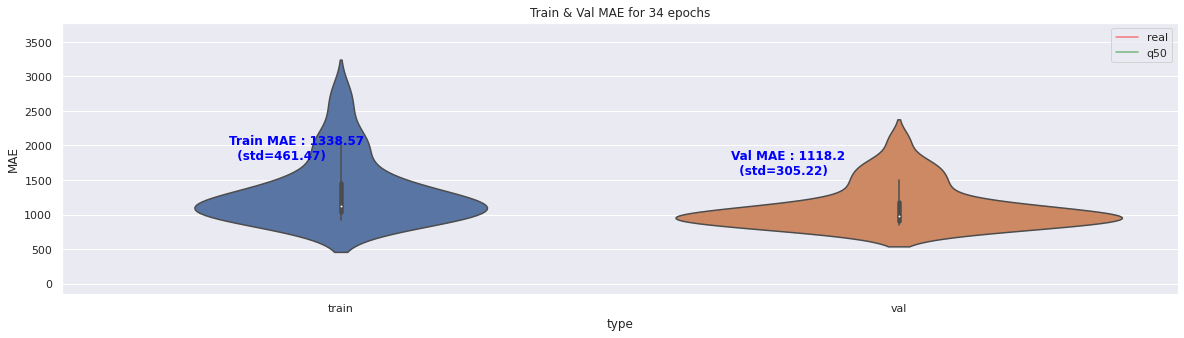

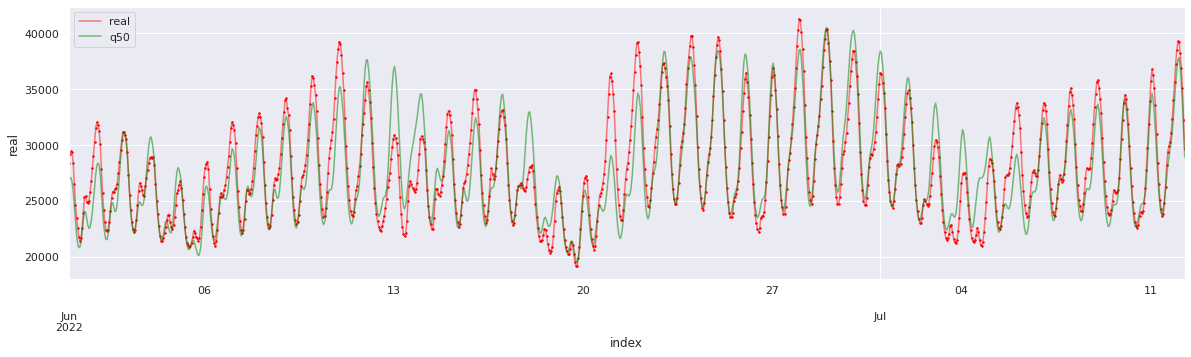

In [ ]:
tmp_test = []
tmp_train = []
tmp_val = []
for i in range(20):
  print('#',i+1)
  ee = experiment(dataset=dataset, lr=lr,
                  BATCH_SIZE = bs, verbose=1, patience=p, MAX_EPOCHS = 200,
                  target_column = target_column, 
                  split_ratio = SPLIT_RATIO ,
                  iftscv=False, # use 3way holdout
                  prediction_offset = prediction_offset,lookback_width = lw,
                  train_from_front=False # default False
                  )
  MAE, __ = ee.make_prediction(verbose=True, plot=True)
  tmp_train.append( ee.MAE_train.mean() )
  tmp_val.append( ee.MAE_val.mean() )
  tmp_test.append(MAE[0])

  print('\n'.join(
        [ f'MAE:{tmp_test}'
        ]
        ))

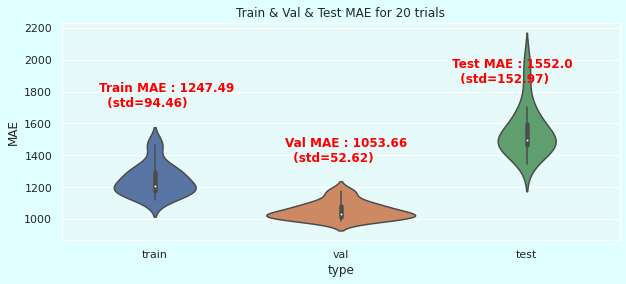

In [ ]:
stats_tab0 = plotly_plot_variance(tmp_train, tmp_val, tmp_test)

In [ ]:
rst = pd.DataFrame({'train_MAE':tmp_train, 'val_MAE':tmp_val, 'test_MAE': tmp_test})
r = pd.concat([
        rst.mean().rename('mean'),
        (round((rst.std()), 4)).rename('std'),
        (rst.std()/rst.mean()).rename('Coef of var'),
        ], axis = 1).reset_index().rename(columns = {'index': 'KPI'}).set_index('KPI')
fig_var0 = draw_stats_table(r, 600, 400)

#### block chaining cv

# 1
qrange: 4000.800000000003 median: 24327.0
Epoch 1/200
22/22 [==============================] - 7s 71ms/step - loss: 0.6968 - MAE: 0.6968 - val_loss: 0.5902 - val_MAE: 0.5902
Epoch 2/200
22/22 [==============================] - 0s 18ms/step - loss: 0.5476 - MAE: 0.5476 - val_loss: 0.6809 - val_MAE: 0.6809
Epoch 3/200
22/22 [==============================] - 0s 18ms/step - loss: 0.5938 - MAE: 0.5938 - val_loss: 0.4063 - val_MAE: 0.4063
Epoch 4/200
22/22 [==============================] - 0s 18ms/step - loss: 0.4426 - MAE: 0.4426 - val_loss: 0.5670 - val_MAE: 0.5670
Epoch 5/200
22/22 [==============================] - 0s 18ms/step - loss: 0.4923 - MAE: 0.4923 - val_loss: 0.3750 - val_MAE: 0.3750
Epoch 6/200
22/22 [==============================] - 0s 18ms/step - loss: 0.4035 - MAE: 0.4035 - val_loss: 0.5015 - val_MAE: 0.5015
Epoch 7/200
22/22 [==============================] - 0s 18ms/step - loss: 0.4462 - MAE: 0.4462 - val_loss: 0.4150 - val_MAE: 0.4150
Epoch 8/200
22/22 [===========

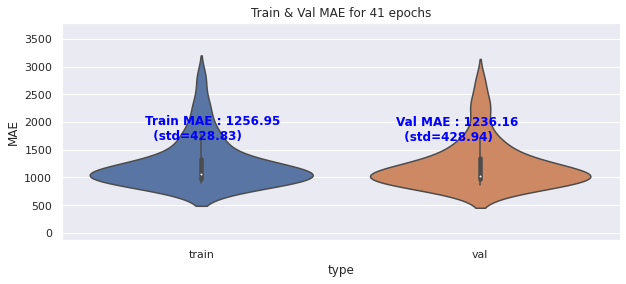

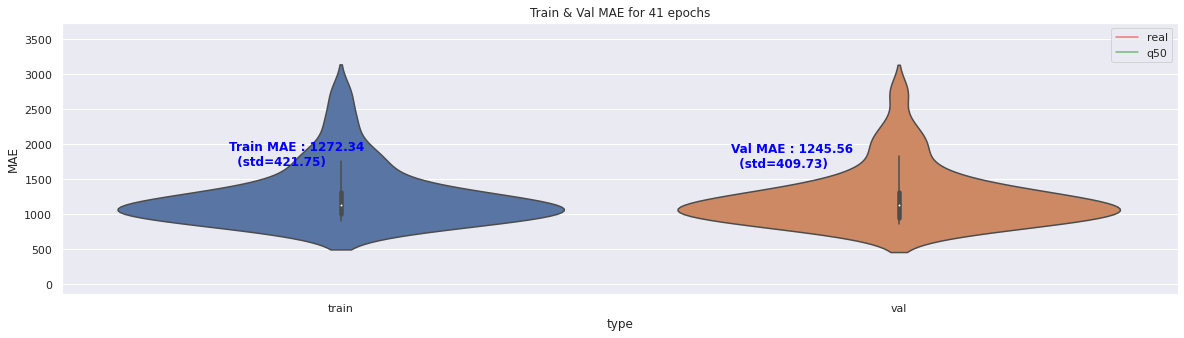

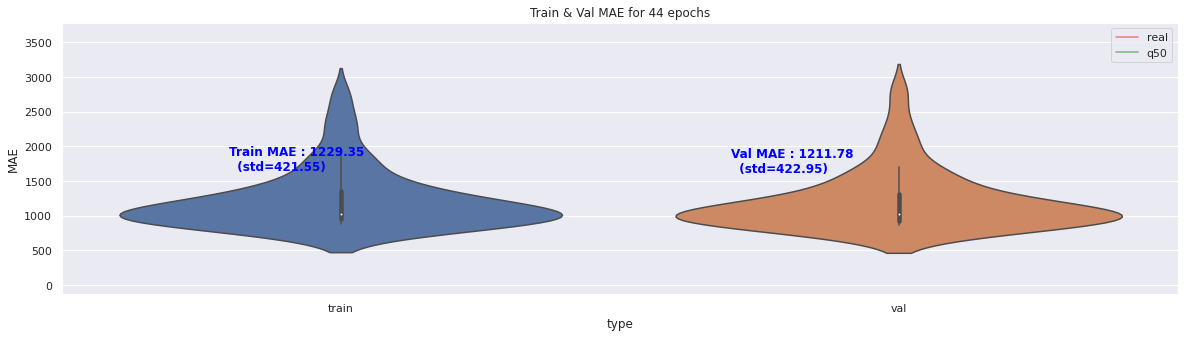

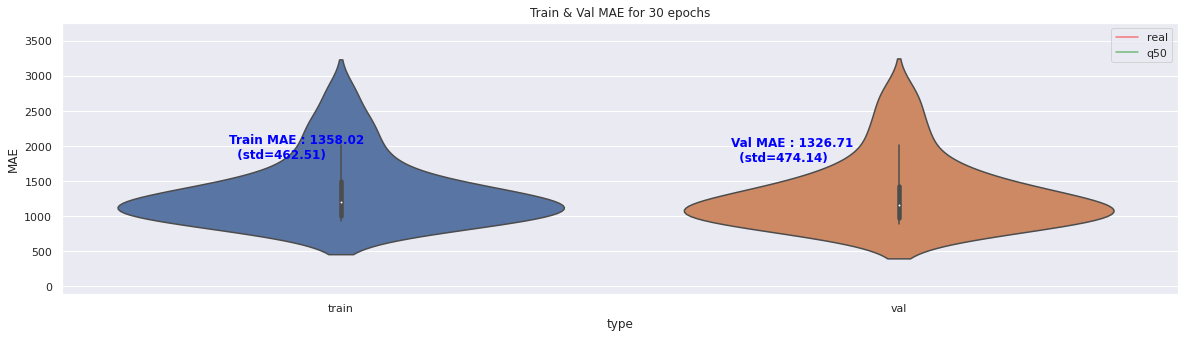

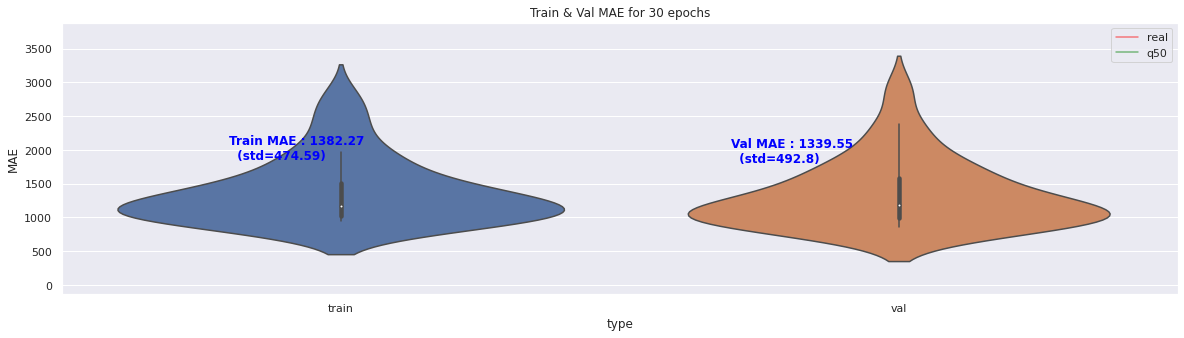

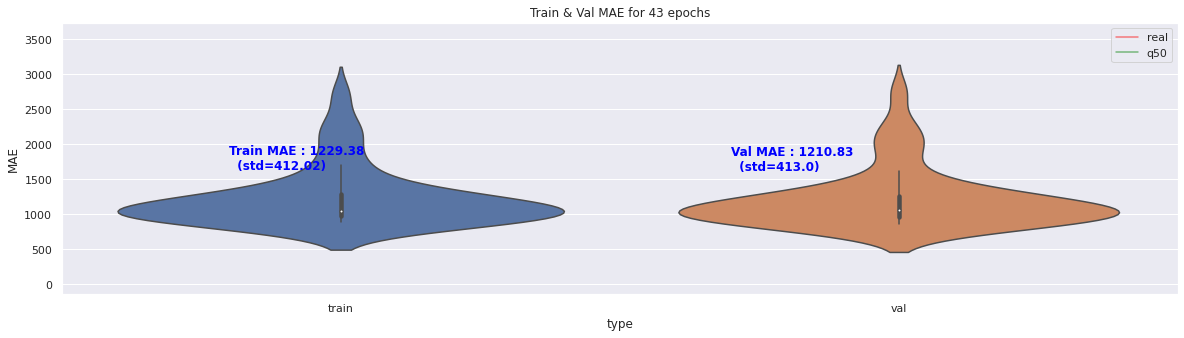

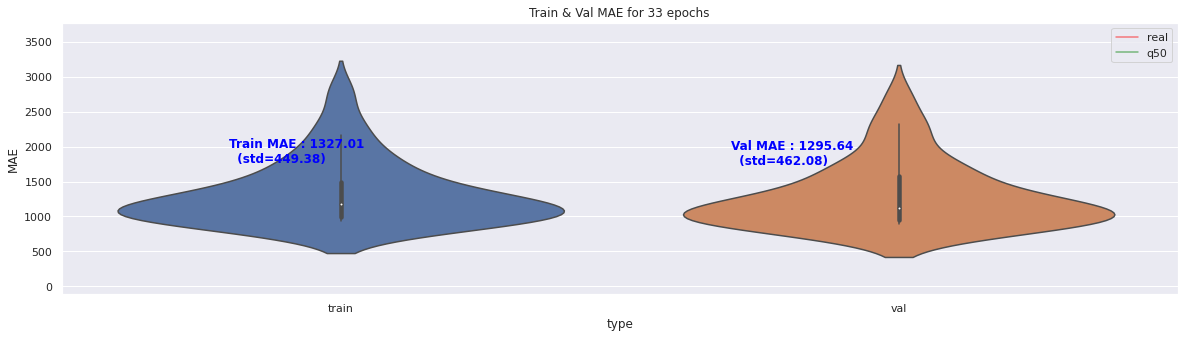

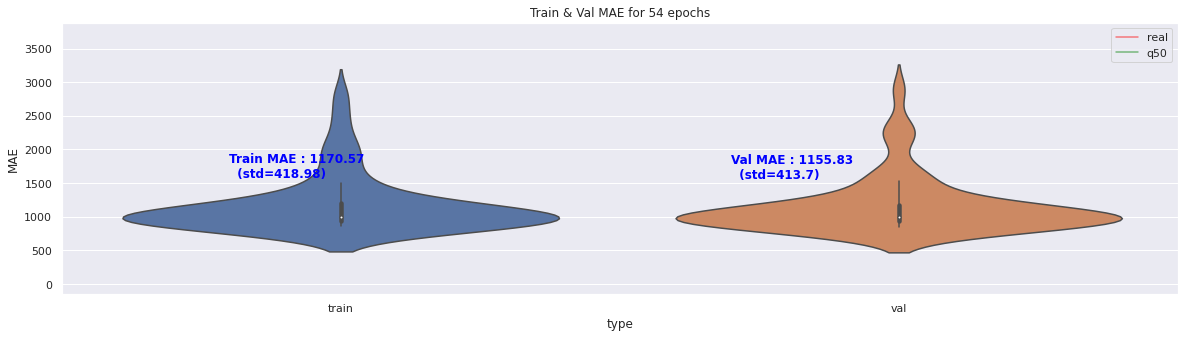

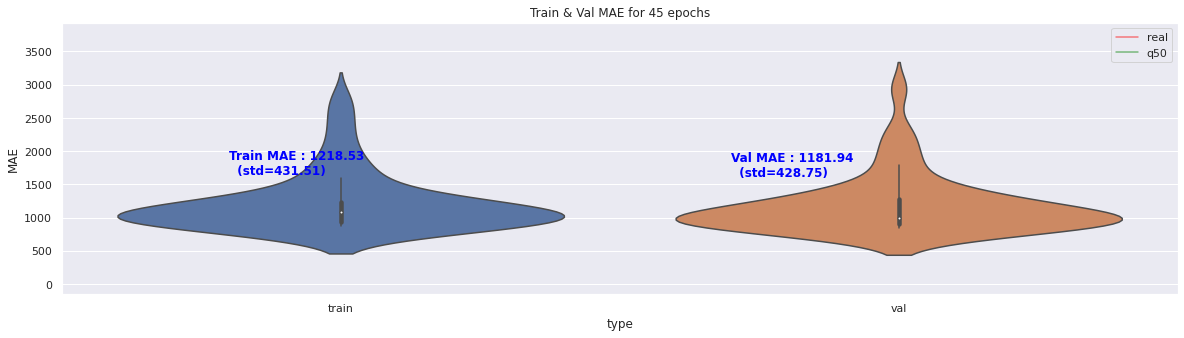

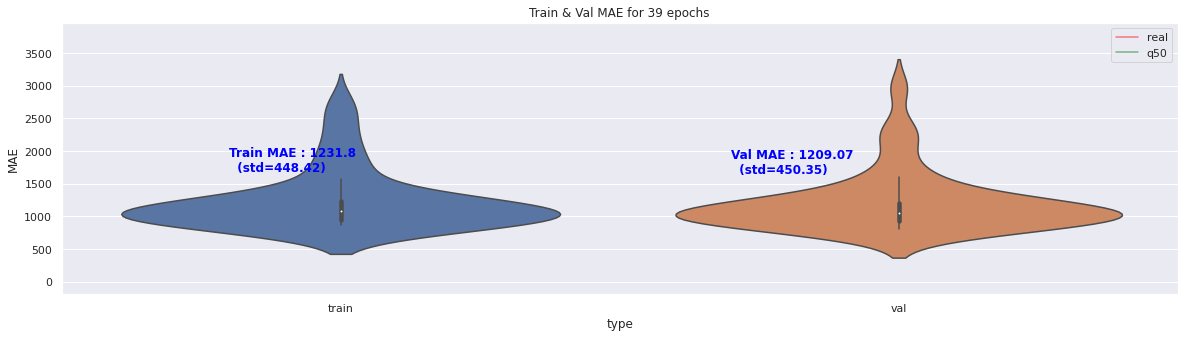

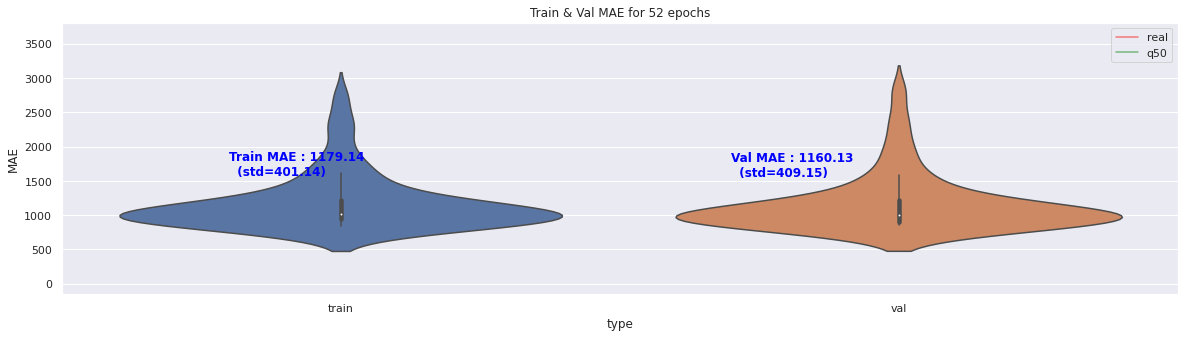

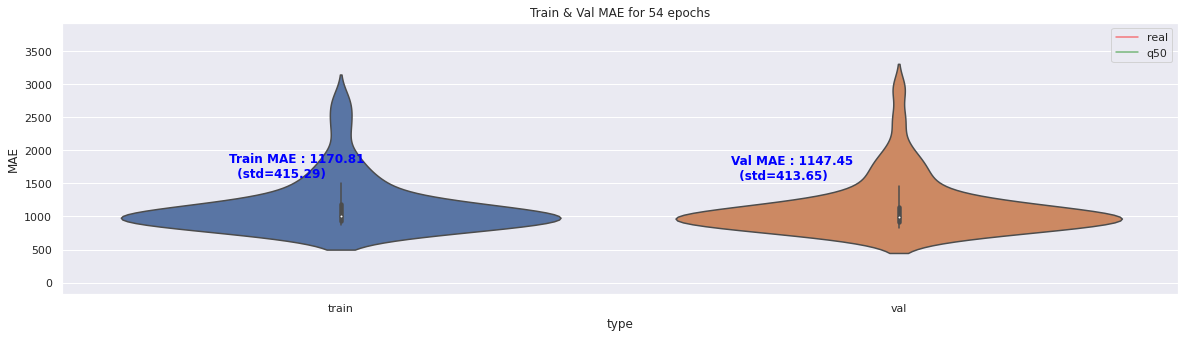

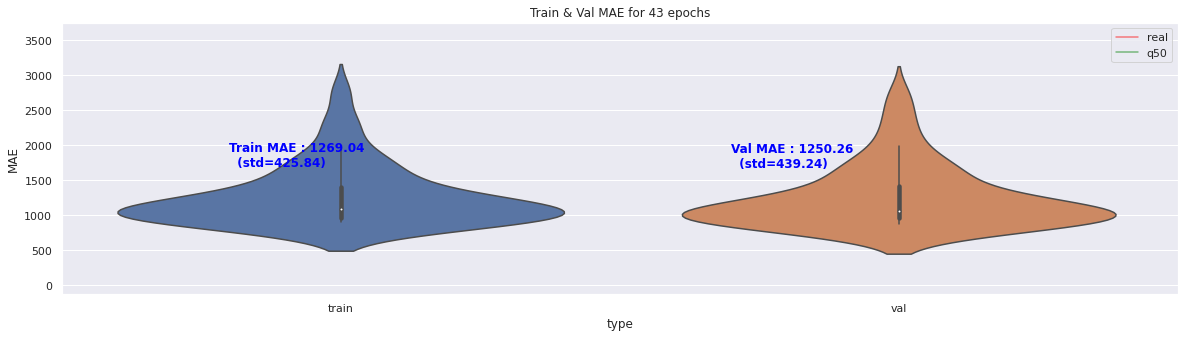

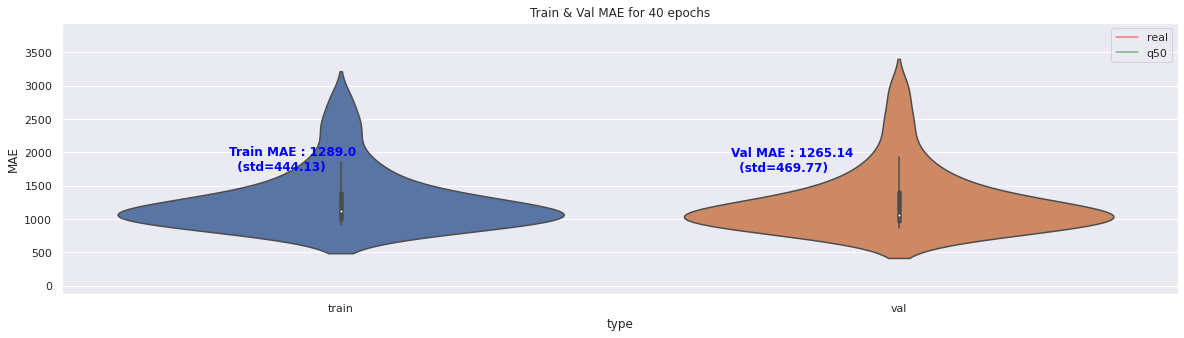

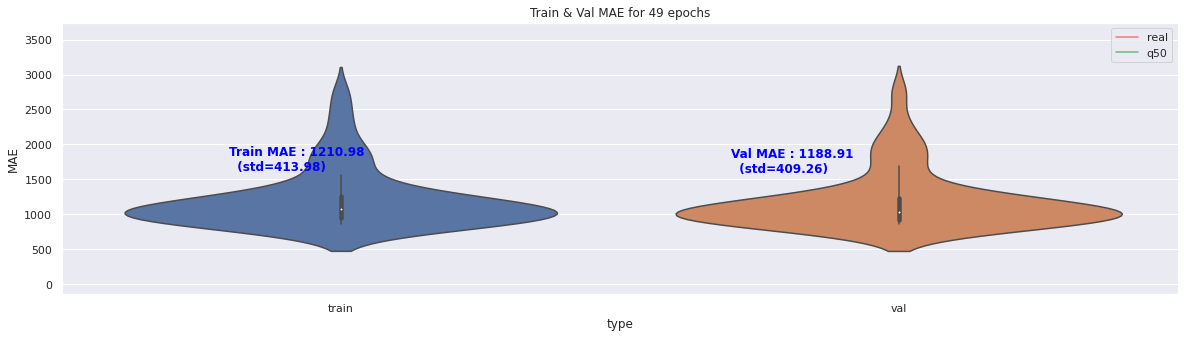

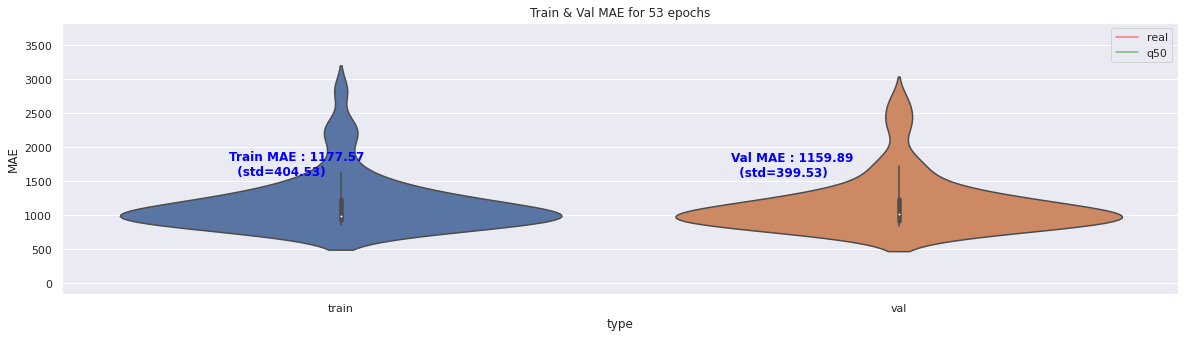

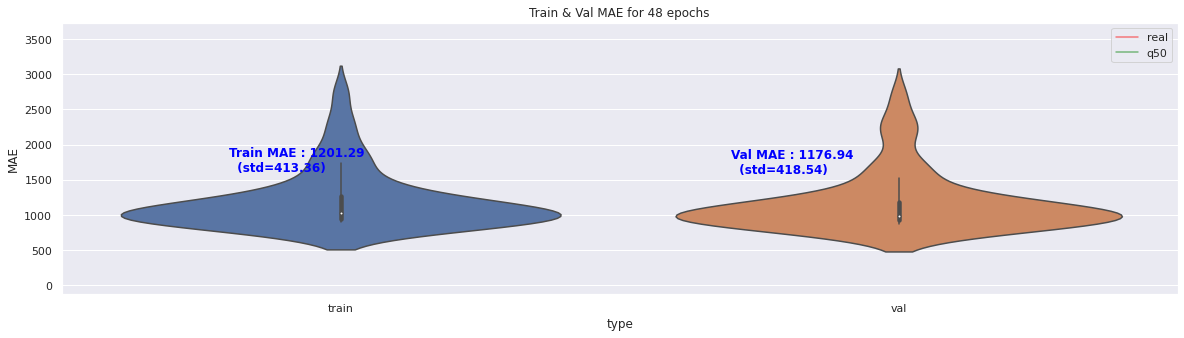

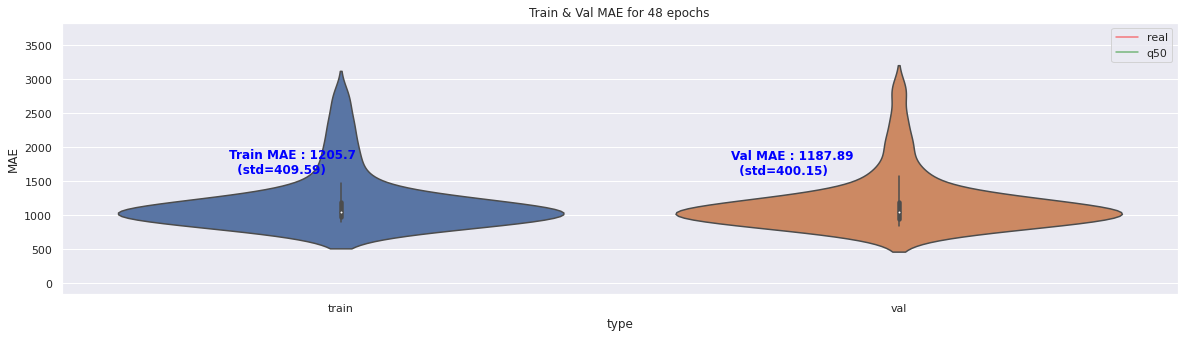

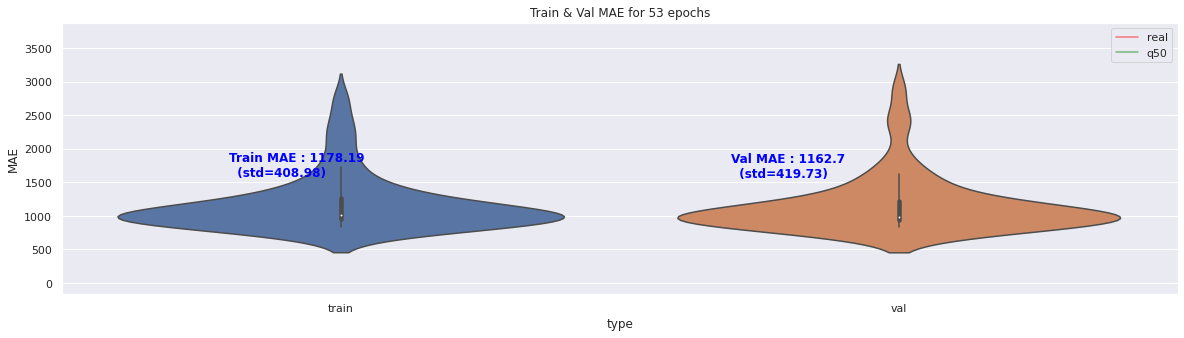

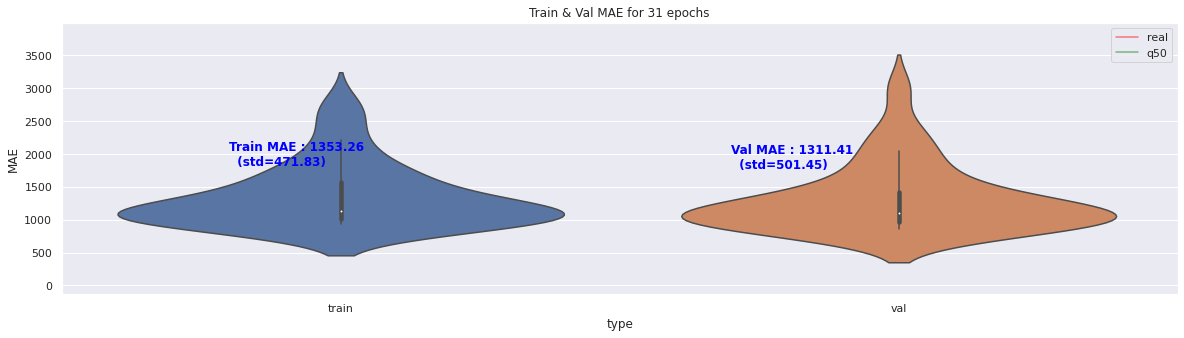

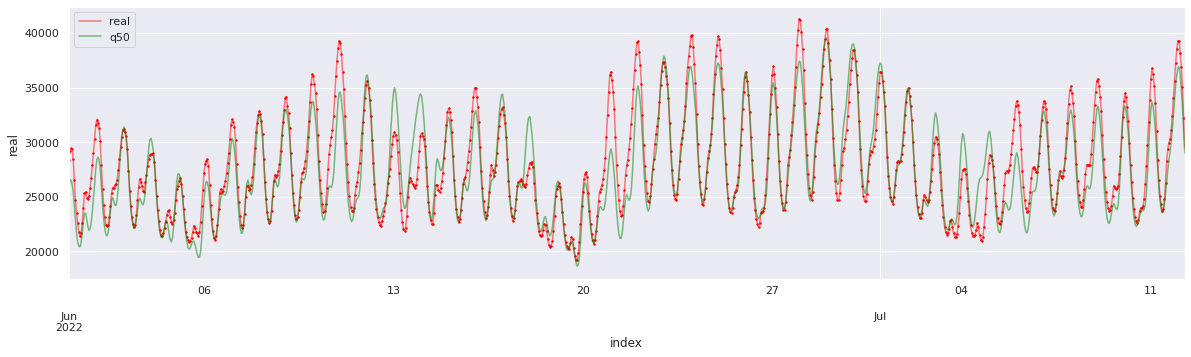

In [ ]:
tmp_test1 = []
tmp_train1 = []
tmp_val1 = []
for i in range(20):
  print('#',i+1)
  ee = experiment(dataset=dataset, lr=lr,
                    BATCH_SIZE = bs, verbose=1, patience=p, MAX_EPOCHS = 200,
                    target_column = target_column, 
                    prediction_offset = prediction_offset,lookback_width = lw,
                    one_train_size=ONE_TRAIN_SIZE,
                    one_val_size = ONE_VAL_SIZE,
                    test_size=TEST_SIZE, 
                    train_from_front=False # default False
                    )
  MAE,  __ = ee.make_prediction(verbose=True, plot=True)
  tmp_train1.append( ee.MAE_train.mean() )
  tmp_val1.append( ee.MAE_val.mean() )
  assert len(tmp_train1) == len(tmp_val1)
  tmp_test1.append(MAE[0])
  print('\n'.join(
        [ f'MAE:{tmp_test1}'
        ]
        ))

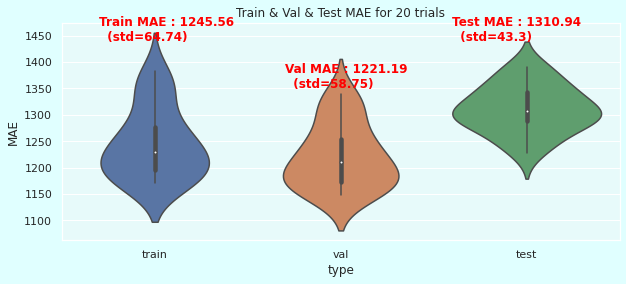

In [ ]:
fig_var1  = plotly_plot_variance(tmp_train1, tmp_val1, tmp_test1)

In [ ]:
rst1 = pd.DataFrame({'train_MAE':tmp_train1, 'val_MAE':tmp_val1, 'test_MAE': tmp_test1})
r1 = pd.concat([
        rst1.mean().rename('mean'),
        (round((rst1.std()), 4)).rename('std'),
        (rst1.std()/rst1.mean()).rename('Coef of var'),
        ], axis = 1).reset_index().rename(columns = {'index': 'KPI'}).set_index('KPI')


stats_tab2 = draw_stats_table(r1, 600, 400)

#### forward chaining cv

# 1
qrange: 4000.800000000003 median: 24327.0
Epoch 1/200
186/186 [==============================] - 8s 21ms/step - loss: 0.4941 - MAE: 0.4941 - val_loss: 0.3624 - val_MAE: 0.3624
Epoch 2/200
186/186 [==============================] - 3s 15ms/step - loss: 0.3071 - MAE: 0.3071 - val_loss: 0.3213 - val_MAE: 0.3213
Epoch 3/200
186/186 [==============================] - 3s 15ms/step - loss: 0.2705 - MAE: 0.2705 - val_loss: 0.2782 - val_MAE: 0.2782
Epoch 4/200
186/186 [==============================] - 3s 15ms/step - loss: 0.2417 - MAE: 0.2417 - val_loss: 0.2550 - val_MAE: 0.2550
Epoch 5/200
186/186 [==============================] - 3s 15ms/step - loss: 0.2369 - MAE: 0.2369 - val_loss: 0.2714 - val_MAE: 0.2714
Epoch 6/200
186/186 [==============================] - 3s 15ms/step - loss: 0.2277 - MAE: 0.2277 - val_loss: 0.2773 - val_MAE: 0.2773
Epoch 7/200
186/186 [==============================] - 3s 15ms/step - loss: 0.2192 - MAE: 0.2192 - val_loss: 0.2299 - val_MAE: 0.2299
Epoch 8/200
186/

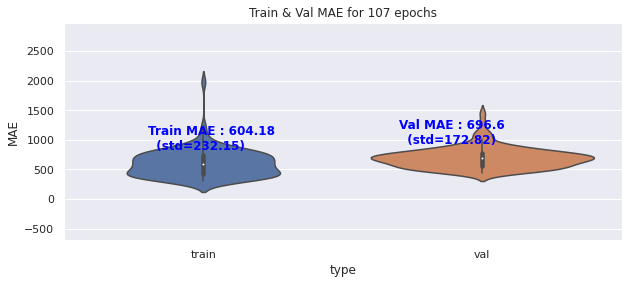

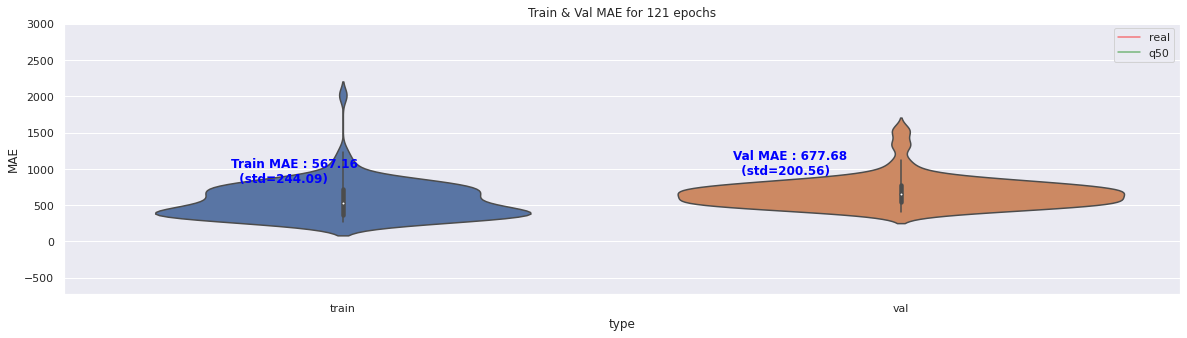

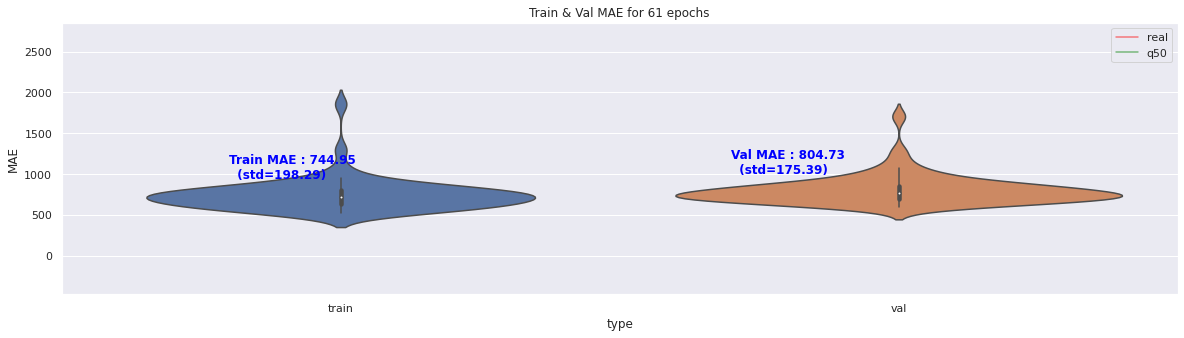

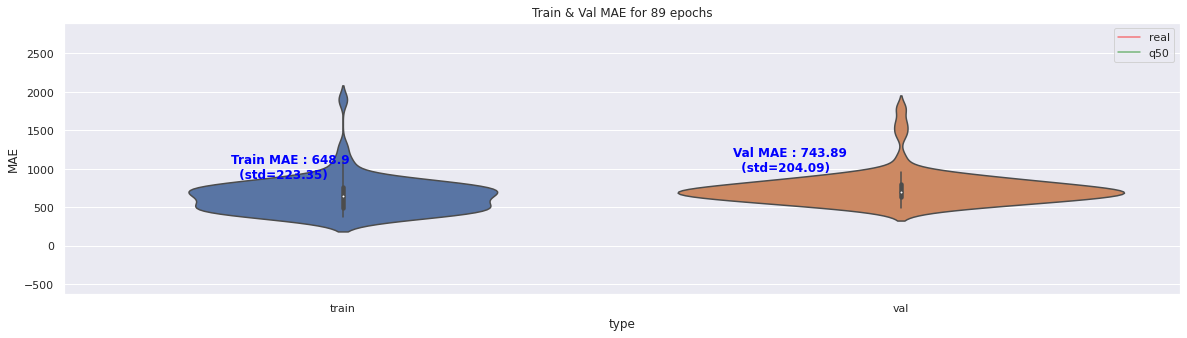

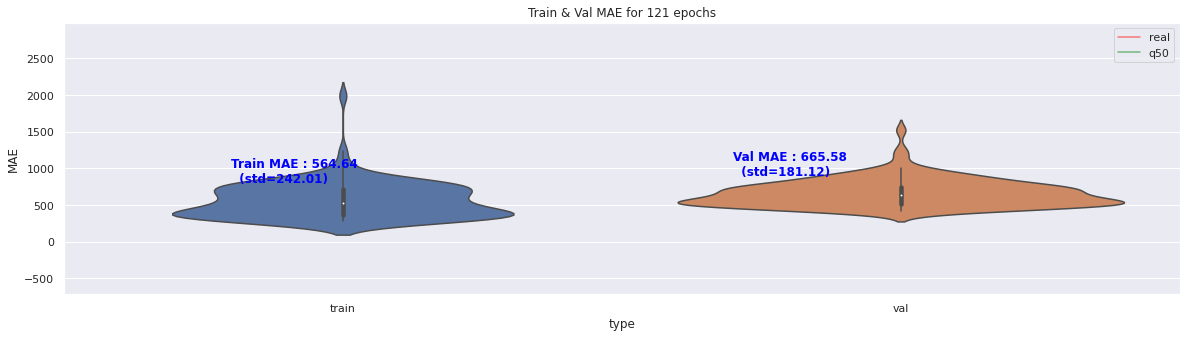

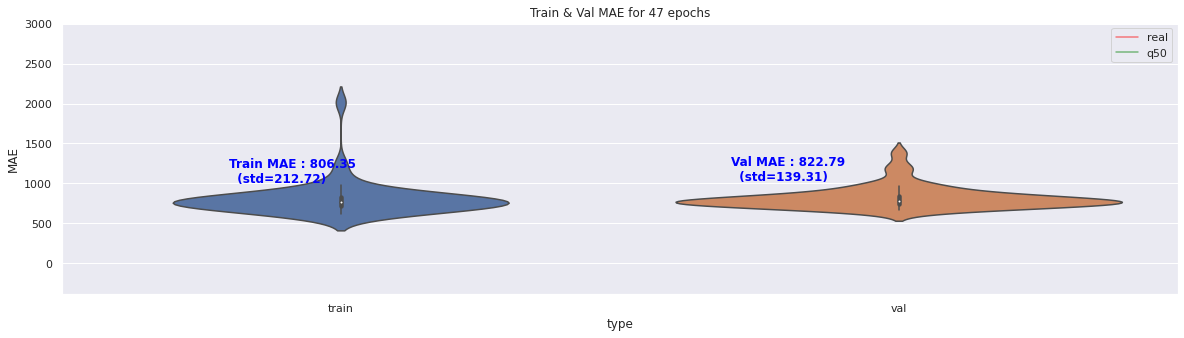

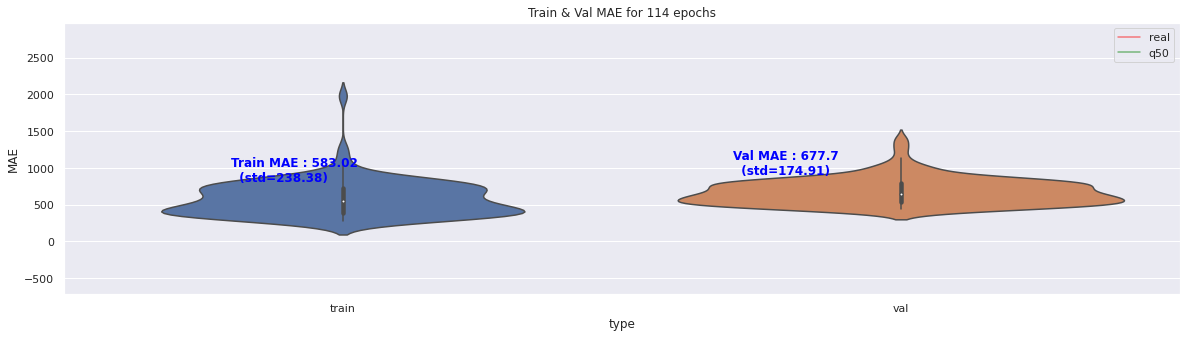

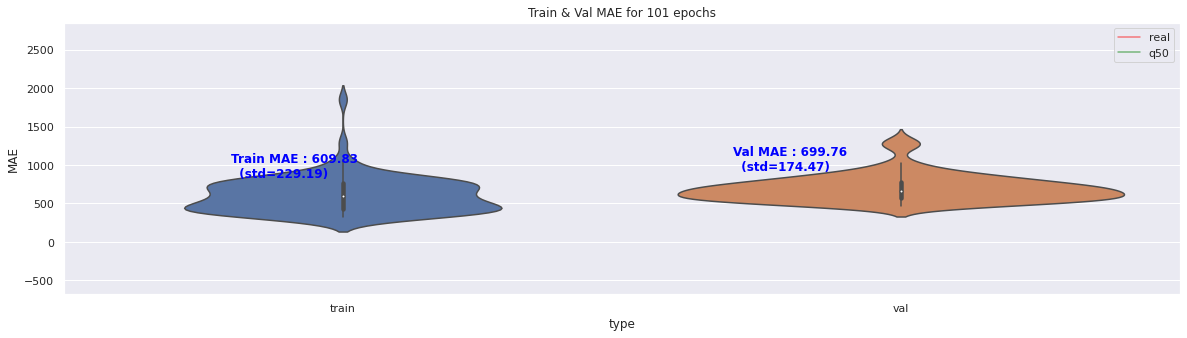

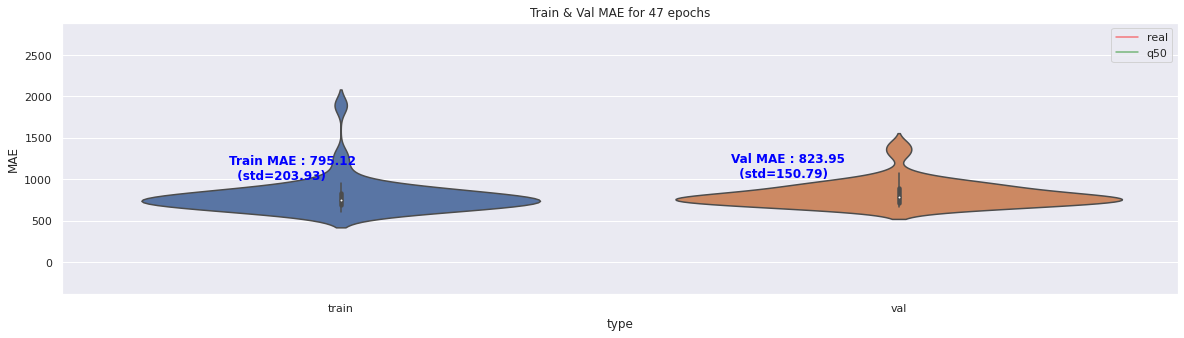

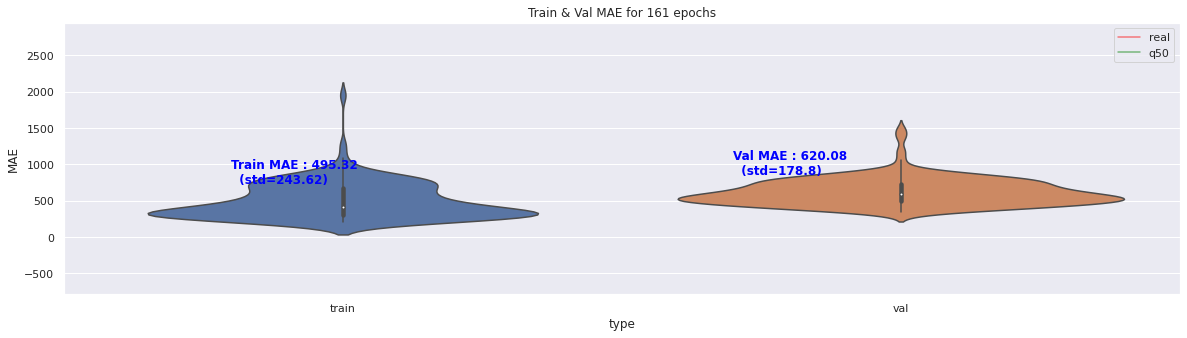

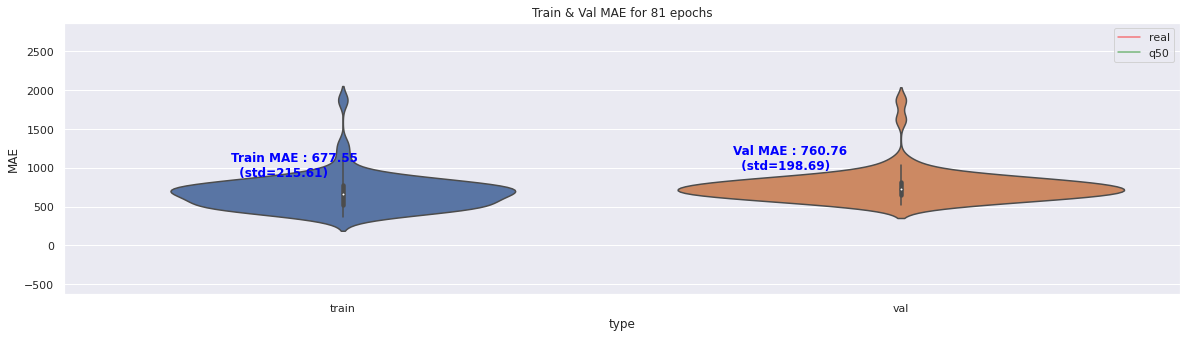

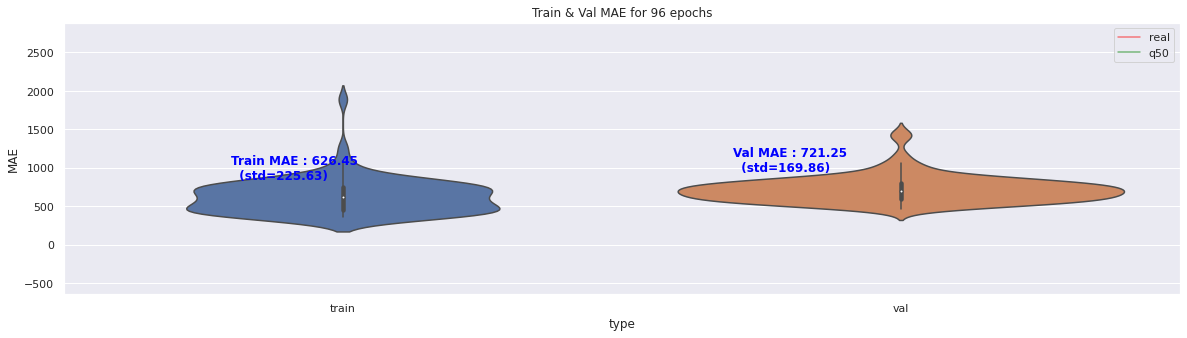

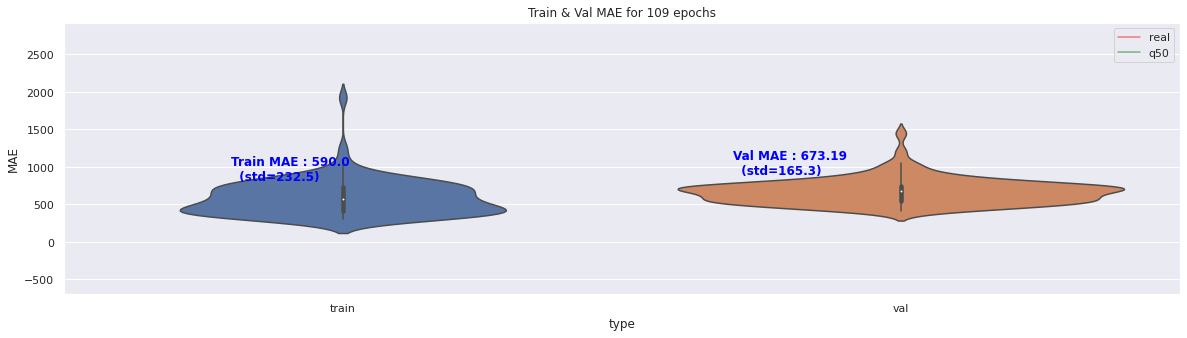

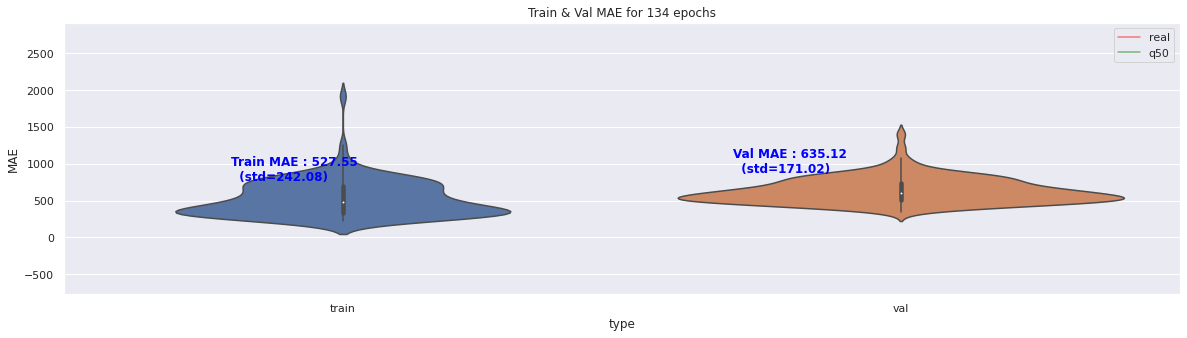

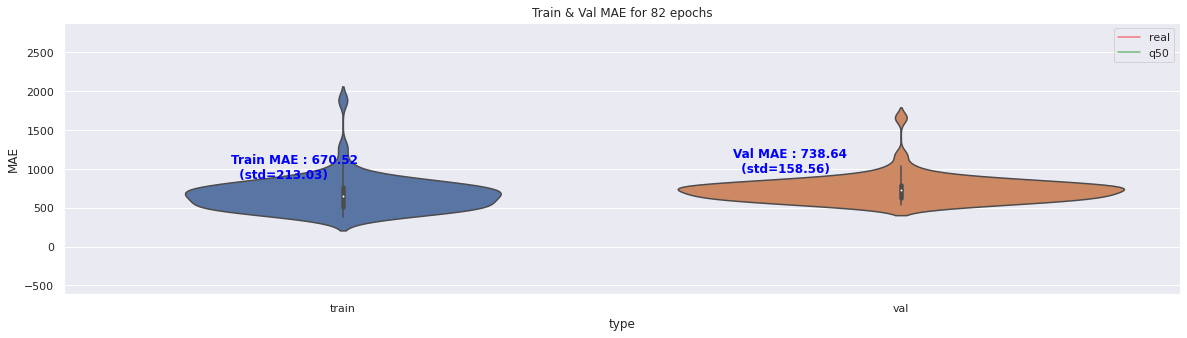

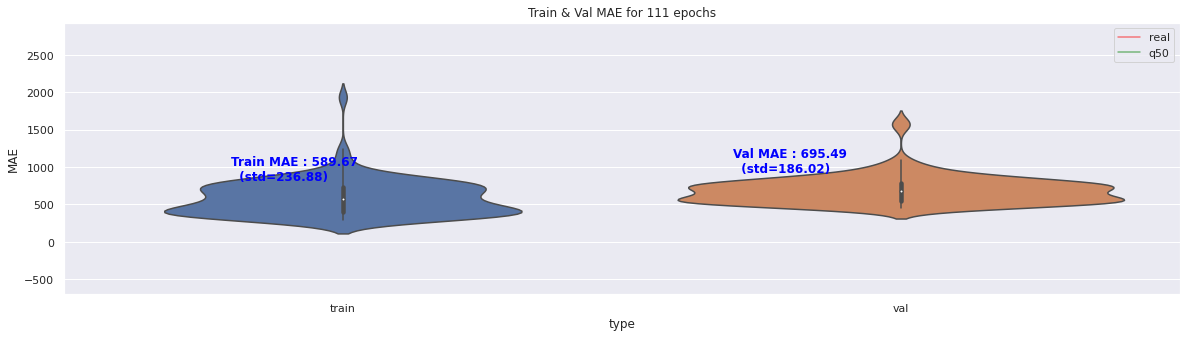

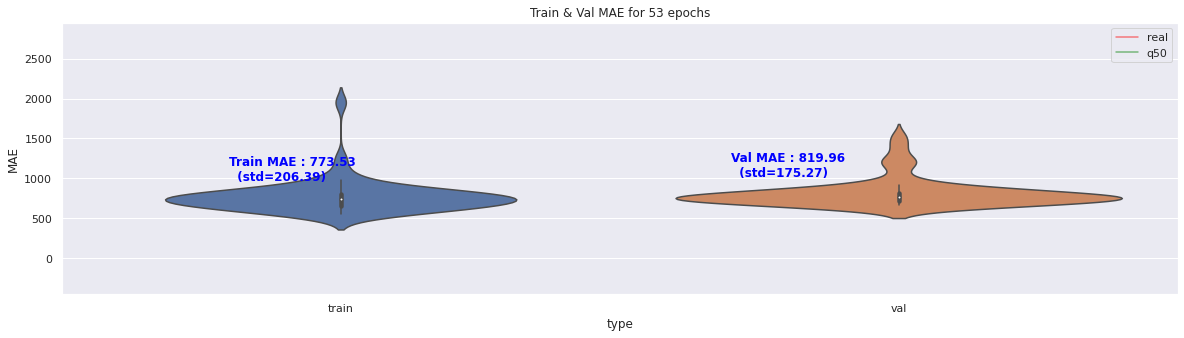

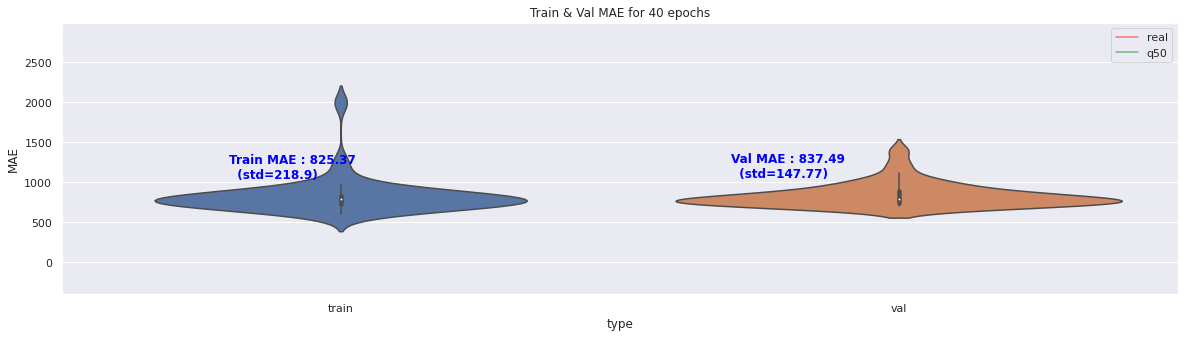

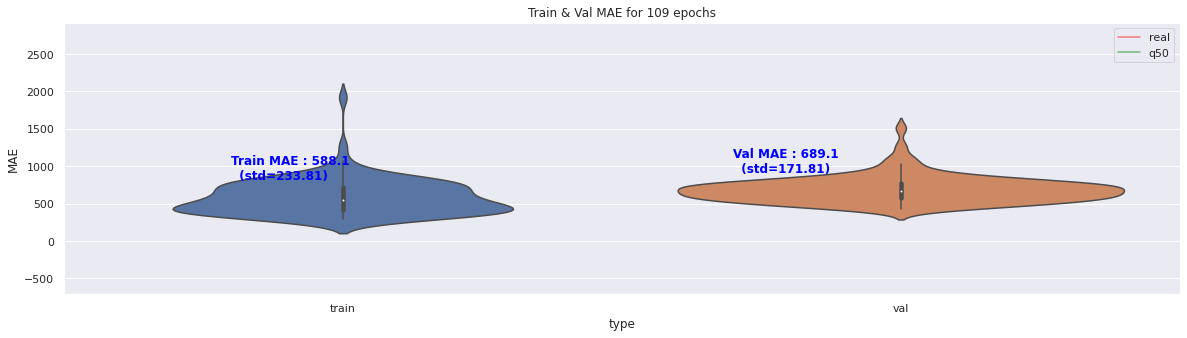

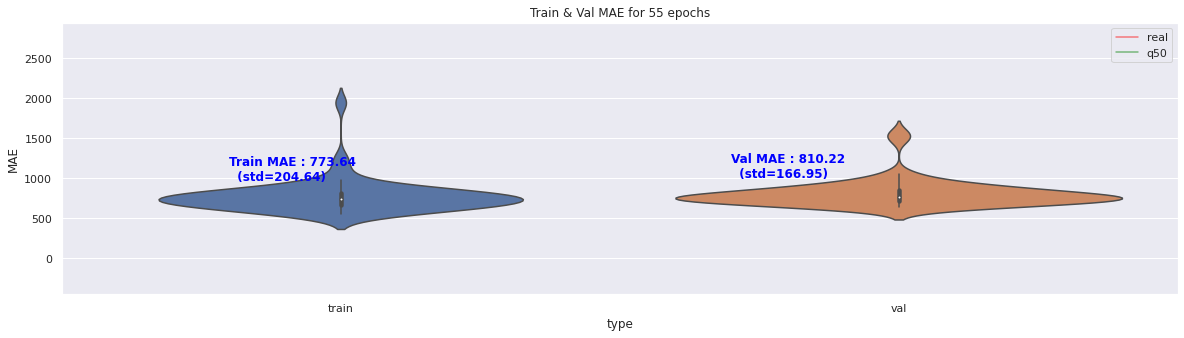

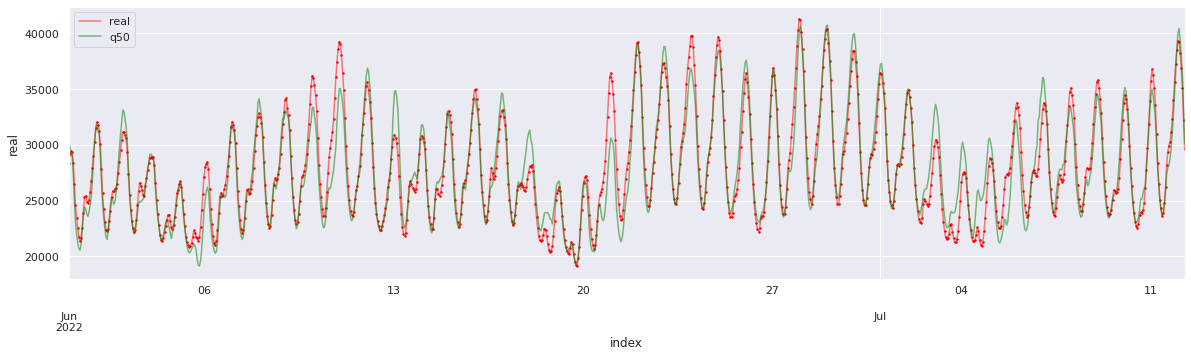

In [ ]:
tmp_test2 = []
tmp_train2 = []
tmp_val2 = []
for i in range(20):
  print('#',i+1)
  ee = experiment(dataset=dataset, lr=lr,
                  BATCH_SIZE = bs, verbose=1, patience=p, MAX_EPOCHS = 200,
                  target_column = target_column, 
                  prediction_offset = prediction_offset,lookback_width = lw,
                  one_train_size=ONE_TRAIN_SIZE,
                  one_val_size = ONE_VAL_SIZE,
                  test_size=TEST_SIZE, 
                  train_from_front=True # default False
  )
  MAE, __ = ee.make_prediction(verbose=True, plot=True)
  tmp_train2.append( ee.MAE_train.mean() )
  tmp_val2.append( ee.MAE_val.mean() )
  assert len(tmp_train2) == len(tmp_val2)
  tmp_test2.append(MAE[0])
  print('\n'.join(
        [ f'MAE:{tmp_test2}'
        ]
        ))

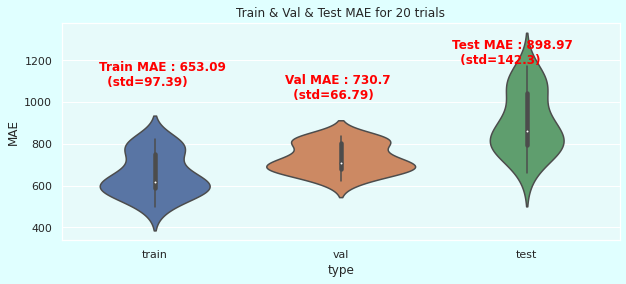

In [ ]:
fig_var2 = plotly_plot_variance(tmp_train2, tmp_val2, tmp_test2)

In [ ]:
rst2 = pd.DataFrame({'train_MAE':tmp_train2, 'val_MAE':tmp_val2, 'test_MAE': tmp_test2})
r2 = pd.concat([
        rst2.mean().rename('mean'),
        (round((rst2.std()), 4)).rename('std'),
        (rst2.std()/rst2.mean()).rename('Coef of var'),
        ], axis = 1).reset_index().rename(columns = {'index': 'KPI'}).set_index('KPI')

stats_tab1 = draw_stats_table(r2, 600, 400)

#### comparisons of var(MAEs)

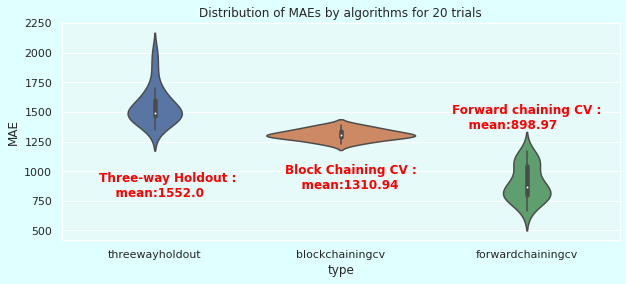

In [ ]:
fig_var_comparison = plotly_plot_variance_comparison(tmp_test, tmp_test1, tmp_test2)

In [ ]:
from scipy import stats
ttest1 = stats.ttest_ind(tmp_test, tmp_test1, equal_var=False)
print(ttest1)
ttest2 = stats.ttest_ind(tmp_test, tmp_test2, equal_var=False)
print(ttest2)
ttest3 = stats.ttest_ind(tmp_test1, tmp_test2, equal_var=False)
print(ttest3)

Ttest_indResult(statistic=6.609473203310788, pvalue=1.1957339409990575e-06)
Ttest_indResult(statistic=13.624843857996524, pvalue=3.658834003649404e-16)
Ttest_indResult(statistic=12.07312269663505, pvalue=2.6432163280411204e-11)
